In [3]:
import utils
import importlib
importlib.reload(utils)
import time
import os
import joblib
import evaluate
importlib.reload(evaluate)
from evaluate import accuracy, compute_PR
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier

## Load Dataset
Inputs have been preprocessed using SMILES, Mordred, and output parsing in the "notebooks" directory. The resulting datasets were saved to the "data" directory, which were removed before publishing for copyright purposes. 

In [4]:
start_time = time.time()

# Create pandas dataframes from X and y datasets
# Check location of X and y datasets before running
# URLs were redacted for copyright purposes
X_url = ''
y_url = ''
X_full = pd.read_csv(X_url, index_col='Unnamed: 0')
y_full = pd.read_csv(y_url, index_col='Unnamed: 0')
print(time.time() - start_time)

25.114323377609253


In [5]:
# View datasets
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9,yield
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000,0.62
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221,0.88
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000,0.76
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000,0.85
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,93.0,50.0,...,12.986667,0,1.499637,0.0,0,0,0.0,0,0.000000,0.79
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512,0.74
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000,0.73
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512,0.55


In [7]:
# Remove unnecessary columns
X_full = X_full.drop(columns=[i for i in X_full.columns if 'Unnamed:' in str(i)])
X_full = X_full.drop(columns=[i for i in X_full.columns if str(i) in ['0_y', '0.09']])
X_full = X_full.drop(['yield'], axis=1)
y_full = y_full.drop(columns=[i for i in y_full.columns if 'Unnamed:' in str(i)])

# View changes
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,93.0,50.0,...,0,12.986667,0,1.499637,0.0,0,0,0.0,0,0.000000
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


In [8]:
y_full

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_75,null_metals,null_ligands,null_solvents,null_additives,null_temp,null_pressures,null_gases,null_other,null_non-binned other
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,0,0,1,1,1
2682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,0,0,1,1,1
2683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,0,0,1,1,1
2684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,0,0,1,1,1


# Creating full GBM models
## SMILES + Descriptors

### Split dataset

In [9]:
# Test indices were chosen randomly in GCN experiments
# and used here for consistency
# Make sure to set this correctly and verify this!
test_path = '../../data/pkr_Y_test_labeled.csv'
test_labels = pd.read_csv(test_path, index_col='Unnamed: 0')
test_labels

,pred_M,pred_L,pred_S,pred_A,pred_T,pred_P,pred_G,pred_O,pred_N
15,['M5'],['L1'],['S1'],['Null'],['T4'],['P2'],['G1'],['O2'],['Null']
26,['M5'],['L1'],['S1'],['Null'],['T5'],['P2'],['G1'],['O2'],['Null']
27,['M5'],['L1'],['S1'],['Null'],['T5'],['P2'],['G1'],['O2'],['Null']
36,['M5'],['L1'],['S1'],['Null'],['T5'],['P2'],['G1'],['O2'],['Null']
46,['M2'],['L4'],['S4'],['A7'],['T3'],['P2'],['G1'],['Null'],['Null']
...,...,...,...,...,...,...,...,...,...
2653,['Null'],['Null'],['S1'],['Null'],['T4'],['P2'],['Null'],['Null'],['Null']
2667,['Null'],['Null'],['S1'],['Null'],['T4'],['P2'],['Null'],['Null'],['Null']
2678,['Null'],['Null'],['S1'],['Null'],['T6'],['P2'],['Null'],['Null'],['Null']
2679,['Null'],['Null'],['S1'],['Null'],['T6'],['P2'],['Null'],['Null'],['Null']


In [10]:
# Get indices of test reactions
test_inds = test_labels.index.values
print(len(test_inds))

262


In [76]:
# Split full dataset based on test indices
X_train = X_full[~X_full.index.isin(test_inds)]
y_train = y_full[y_full.index.isin(X_train.index)]
X_test = X_full[X_full.index.isin(test_inds)]
y_test = y_full[y_full.index.isin(test_inds)]

# Check sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2347, 2304), (2347, 85), (262, 2304), (262, 85))

In [77]:
X_train['250']

0       91.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
2680     0.0
2682     0.0
2683     0.0
2684     0.0
2685     0.0
Name: 250, Length: 2347, dtype: float64

## Construct label trellis

In [12]:
def learn_dep_matrix(df):
    """
    Construct dependency matrix given a dataframe of label vectors
    
    ARGUMENTS
        (pandas DataFrame)df: dataframe of label vectors
        
    RETURNS
        (np.array)mat: dependency matrix containing mutual information
                       for all label pairs
    """
    # Initialize empty square matrix
    mat = np.zeros((len(df.columns), len(df.columns)))
    
    # Iterate over each label pair combination and fill in matrix
    # positions with their mutual info scores
    for i, col in enumerate(df.columns):
        for j, other_col in enumerate(df.columns):
            if j < i:
                mat[i, j] = mat[j, i]
            else:
                mat[i, j] = mutual_info_score(df[col], df[other_col])
    return mat

In [13]:
# Construct dependency matrix of output label correlations
start_time = time.time()
dep_matrix = learn_dep_matrix(y_train)
print(time.time() - start_time)
print(dep_matrix.shape)

3.9326119422912598
(85, 85)


In [14]:
def form_trellis(df, mat, first_reagent=0):
    """
    Construct trellis grid based on dependency matrix to be used for ordering
    chained classifiers. See algorithm from Read et al. Pattern Recognition
    2015, 48, 6, 2096-2109. DOI: 10.1016/j.patcog.2015.01.004. Also found at
    http://arxiv.org/abs/1501.04870
    
    ARGUMENTS:
        (pandas DataFrame)df: dataframe of output vectors containing labels
                                to be fit into trellis
        (np.array)mat: dependency matrix containing label-pair mutual
                        information scores
        (int)first_reagent: label index to initialize trellis ordering
        
    RETURNS:
        (list)struct: list of list of tuples. high-level list contains each
                        row of the trellis as sub-list. rows contain each entry
                        as a tuple of the: (label index from the dataset 
                        dictionary, label name, mutual info score)
    """
    # Set up empty square grid to construct trellis
    col_set = set(df.columns)
    n_cols = len(df.columns)
    width = int(np.ceil(np.sqrt(n_cols)))
    struct = [[None for _ in range(width)] for _ in range(width)]
    
    # Iterate through trellis grid filling in labels
    for row in range(width):
        for col in range(width):
            if len(col_set) == 0:
                break
            # Set top-left label as specified first_reagent
            elif row == 0 and col == 0:
                struct[row][col] = (first_reagent, df.columns[first_reagent], 0)
            # Calculate combined mutual info scores between remaining labels
            # and labels in available trellis directions (from Read
            # et al., models take input from positions up, left, and 
            # up-left of the current bin, unless those directions extend
            # out of the grid)
            else:
                scores = np.zeros(n_cols)
                if row - 1 >= 0:
                    scores += mat[struct[row - 1][col][0]]
                if col - 1 >= 0:
                    scores += mat[struct[row][col - 1][0]]
                if row - 1 >= 0 and col - 1 >= 0:
                    scores += mat[struct[row - 1][col - 1][0]]
                
                # Fill in current position with the label that maximizes the
                # summed mutual info score with the upstream bins
                scored_cols = list(zip(range(n_cols), df.columns, scores))
                ranked_cols = sorted(scored_cols, key=lambda x: x[2], reverse=True)
                for i, ranked_col, score in ranked_cols:
                    if ranked_col in col_set:
                        #print(i, ranked_col, score)
                        struct[row][col] = (i, ranked_col, score)
                        break
            #print(row, col, struct[row][col])
            col_set.remove(struct[row][col][1])
    return struct

In [15]:
# Create trellis grid from output vectors and their dependency matrix
start_time = time.time()
struct = form_trellis(y_train, dep_matrix)

# View top row of the trellis
print(time.time() - start_time)
print(struct[0])

0.0058040618896484375
[(0, 'reagent_0', 0), (76, 'null_metals', 0.14862353419337637), (61, 'reagent_61', 0.1605151725319796), (82, 'null_gases', 0.6824298017323878), (79, 'null_additives', 0.10240492986284261), (39, 'reagent_39', 0.18618482976838682), (25, 'reagent_25', 0.1317078985730195), (24, 'reagent_24', 0.0716279245022805), (26, 'reagent_26', 0.049107715237996175), (5, 'reagent_5', 0.02379513504675787)]


In [16]:
# View trellis 
id_trellis = [[reagent[0] if type(reagent) == tuple else reagent for reagent in row] for row in struct]
id_trellis_df = pd.DataFrame(id_trellis)
id_trellis_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,76.0,61.0,82.0,79.0,39.0,25.0,24.0,26.0,5.0
1,1.0,33.0,58.0,59.0,40.0,51.0,55.0,27.0,54.0,52.0
2,83.0,62.0,60.0,56.0,11.0,53.0,18.0,77.0,19.0,2.0
3,63.0,4.0,12.0,37.0,69.0,28.0,42.0,32.0,22.0,78.0
4,29.0,48.0,75.0,84.0,20.0,36.0,8.0,68.0,31.0,66.0
5,71.0,50.0,64.0,41.0,57.0,65.0,30.0,10.0,67.0,3.0
6,7.0,16.0,46.0,13.0,34.0,72.0,35.0,9.0,6.0,45.0
7,43.0,44.0,23.0,38.0,21.0,15.0,70.0,47.0,14.0,73.0
8,74.0,17.0,49.0,80.0,81.0,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# View dependency matrix
pd.DataFrame(dep_matrix).round(3)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,0.537,0.035,0.014,0.010,0.004,0.003,0.003,0.005,0.004,0.002,...,0.004,0.149,0.000,0.002,0.028,-0.0,-0.0,0.000,0.008,0.004
1,0.035,0.378,0.007,0.005,0.002,0.002,0.002,0.002,0.002,0.001,...,0.008,0.075,0.000,0.003,0.018,0.0,0.0,0.084,0.018,0.008
2,0.014,0.007,0.208,0.002,0.001,0.001,0.001,0.001,0.001,0.000,...,0.008,0.030,0.049,0.018,0.022,0.0,0.0,0.001,0.000,0.008
3,0.010,0.005,0.002,0.156,0.001,0.000,0.000,0.001,0.001,0.000,...,0.002,0.020,0.004,0.001,0.009,0.0,0.0,0.009,0.005,0.002
4,0.004,0.002,0.001,0.001,0.086,0.000,0.000,0.000,0.000,0.000,...,0.000,0.009,0.027,0.001,0.008,-0.0,-0.0,0.011,0.036,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,...,-0.000,0.000,0.000,0.000,-0.000,0.0,0.0,-0.000,0.000,-0.000
81,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,...,-0.000,0.000,0.000,0.000,-0.000,0.0,0.0,-0.000,0.000,-0.000
82,0.000,0.084,0.001,0.009,0.011,0.009,0.010,0.009,0.014,0.006,...,0.000,0.161,0.025,0.000,0.102,-0.0,-0.0,0.682,0.000,0.000
83,0.008,0.018,0.000,0.005,0.036,0.004,0.002,0.003,0.006,0.001,...,0.001,0.008,0.002,0.000,0.000,0.0,0.0,0.000,0.381,0.001


In [18]:
def convert_2d_tuples_to_lists(struct):
    """
    Converts tuples to lists within trellis structure. Expands None type
    entries to lists of None for compatability
    
    ARGUMENTS:
        (list)struct: trellis structure as list of list of tuples
        
    RETURNS:
        (list): list of list of lists
    """
    return [[list(cell) if cell is not None else [None, None, None]  for cell in row] for row in struct]

In [19]:
# Convert trellis tuples to lists
struct_lists = convert_2d_tuples_to_lists(struct)

# Create trellis arrays containing indices and scores only
reagent_id_struct = np.array(struct_lists)[:,:,0]
reagent_score_struct = np.array(struct_lists)[:,:,2]

In [24]:
# Substitute names based on reagent role using IDs from the dataset dictionary.
# Dictionaries are found in the repository directory data/all_dictionaries/
n_metals = 18
n_ligands = 6
n_bases = 0
n_solvents = 15
n_additives = 11
n_temps = 7
n_pressures = 4
n_gases = 1
n_other = 13
n_non_binned_other = 1
total_reagents = n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_pressures + n_gases + n_other + n_non_binned_other

# Find cutoff locations between categories in reagent list
cutoffs = [
    0,
    n_metals,
    n_metals + n_ligands,
    n_metals + n_ligands + n_bases + n_solvents,
    n_metals + n_ligands + n_bases + n_solvents + n_additives,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_pressures,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_pressures + n_gases,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_pressures + n_gases + n_other,
    n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_pressures + n_gases + n_other + n_non_binned_other
]
category_names = [
    'metals', 'ligands', 'solvents', 'additives', 'temp', 'pressures', 'gases', 'other', 'non-binned other'
]

category_initials = [
    'M', 'L', 'S', 'A', 'T', 'P', 'G', 'O', 'N'
]

In [25]:
cutoffs

[0, 18, 24, 39, 50, 57, 61, 62, 75, 76]

In [26]:
def reagent_id_to_label(reagent_id, cutoffs, category_initials):
    """
    Creates named bin labels as appear in the manuscript in the format
    {category_initial}{index}
    
    ARGUMENTS:
        (int)reagent_id: reagent index from dataset dictionary
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each category
                                ordered to match cutoffs
        
    RETURNS:
        (str): shorthand label for the reagent 
    """
    if reagent_id is None:
        return None
    # Handle null labels added at end of dictionary
    if reagent_id >= cutoffs[-1]:
        return category_initials[reagent_id - cutoffs[-1]] + "_NULL"
    for i, cutoff in enumerate(cutoffs):
        if reagent_id < cutoff:
            #print(reagent_id, cutoff, i)
            return category_initials[i - 1] + str(reagent_id - cutoffs[i - 1] + 1)

In [27]:
# Re-make trellis with fully labelled bins 
reagent_label_struct = np.empty(id_trellis_df.shape).astype(str)
for i in range(id_trellis_df.shape[0]):
    for j in range(id_trellis_df.shape[1]):
        reagent_label_struct[i, j] = reagent_id_to_label(
            (id_trellis[i][j]), cutoffs, category_initials
        )

In [28]:
# View trellis as labelled dataframe
reagent_label_struct_df = pd.DataFrame(reagent_label_struct)
reagent_label_struct_df

,0,1,2,3,4,5,6,7,8,9
0,M1,M_NULL,G1,G_NULL,A_NULL,A1,S2,S1,S3,M6
1,M2,S10,P2,P3,A2,T2,T6,S4,T5,T3
2,O_NULL,O1,P4,T7,M12,T4,L1,L_NULL,L2,M3
3,O2,M5,M13,S14,O8,S5,A4,S9,L5,S_NULL
4,S6,A10,N1,N_NULL,L3,S13,M9,O7,S8,O5
5,O10,T1,O3,A3,P1,O4,S7,M11,O6,M4
6,M8,M17,A8,M14,S11,O11,S12,M10,M7,A7
7,A5,A6,L6,S15,L4,M16,O9,A9,M15,O12
8,O13,M18,A11,T_NULL,P_NULL,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None


In [29]:
# View trellis scores as dataframe
reagent_score_struct_df = pd.DataFrame(reagent_score_struct)
reagent_score_struct_df

,0,1,2,3,4,5,6,7,8,9
0,0,0.148624,0.160515,0.68243,0.102405,0.186185,0.131708,0.0716279,0.0491077,0.0237951
1,0.0351017,0.0538088,0.0844874,0.233286,0.135261,0.170539,0.104031,0.0536504,0.0398639,0.0473093
2,0.0183974,0.0779198,0.133582,0.0864512,0.0397533,0.0700139,0.051156,0.118731,0.0841367,0.0723014
3,0.041782,0.115446,0.00882809,0.0281007,0.0401666,0.0258803,0.0864185,0.0431177,0.0320704,0.0205004
4,0.00188384,0.0154242,0.0028659,0.453932,0.0134747,0.0199531,0.015342,0.0241108,0.00845676,0.0323149
5,0.00742105,0.00605204,0.0128427,0.0126692,0.0092566,0.00790155,0.00503278,0.0228507,0.0238489,0.00158856
6,8.68707e-05,0.00655655,0.00130188,0.0225356,0.00121302,0.00293717,0.000730899,0.0295646,0.000277231,0.00332919
7,0.000182111,0.00028925,0.0260242,0.000109607,0.000166756,0.000959913,0.00012811,0.000159408,0.000113341,7.74514e-05
8,2.94163e-05,4.65409e-05,2.07801e-05,1.76682e-15,8.82107e-16,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None


In [30]:
# Save trellises
reagent_label_struct_df.to_csv('pkr_trellis_label_struct.csv', index=True)
reagent_score_struct_df.to_csv('pkr_trellis_score_struct.csv', index=True)

# Train GBM classifiers
## Binary relevance method (BM)

In [31]:
def train_lgbm_classifier(X_train, y_train, model_file_name):
    """
    Trains one LightGBM binary classifier for every bin in the label space
    under multi-label classification approach
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        (str)model_file_name: name of model file to be saved (should be
                                full string with file type)
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    # Initialize classifier
    clf = OneVsRestClassifier(LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    ))
    
    # Fit classifier and save model
    clf.fit(X_train, y_train)
    joblib.dump(clf, model_file_name)
    return clf

In [32]:
def get_top_k_preds(y_pred_proba, cutoffs, category_initials,
                    k=3, include_nulls=True):
    """
    Get top-k predicted rankings for reagents in each dictionary category
    
    ARGUMENTS:
        (array)y_pred_proba: predicted probability vectors for example set 
        (int)k: top-k ranking limit to be assessed
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: make prediction on null labels, i.e., absence 
                                of a label from each category
                                    
    RETURNS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["pred_" + initial for initial in category_initials]
    all_preds = []
    
    # Create categorical rankings for each reaction in prediction set 
    for row in range(len(y_pred_proba)):
        reaction_preds = []
        for i in range(len(cutoffs) - 1):
            category_preds = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            preds = y_pred_proba[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_pred = y_pred_proba[row][cutoffs[-1]+i]
                preds = np.hstack((preds, null_pred))
                
            # Find indices of top-k predicted labels
            top_k_preds_inds = np.argsort(-preds)[:k]
            
            # Create final list for category
            for ind in top_k_preds_inds:
                if ind == num_category_labels:
                    category_preds.append('Null')
                else:
                    category_preds.append(category_initials[i] + str(ind + 1))
                    
            # Add category predictions to reaction prediction set
            reaction_preds.append(category_preds)
        
        # Add reaction predictions to full set
        all_preds.append(reaction_preds)
    
    # Fill in dataframe
    preds_df = pd.DataFrame(all_preds, columns=columns)
    return preds_df

def get_type_count(cutoffs, category_initials):
    """
    Returns dictionary with the number of labels in each dataset category
    
    ARGUMENTS:
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
    RETURNS:
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    """
    # Create dictionary from category initials and cutoffs
    type_count = {
        category_initials[i]: cutoffs[i+1] - cutoffs[i] + 1 
        for i in range(len(category_initials))
}
    return type_count

In [33]:
def label_ground_truth(gt_df, cutoffs, category_initials, include_nulls=True):
    """
    Convert ground truth (gt) label arrays to same format as predictions
    
    ARGUMENTS:
        (pd.DataFrame)gt_df: dataframe of output vectors for test set
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: whether null labels, i.e., absence of a label
                                from each category are explicitly included
                                in output vectors
                                    
    RETURNS:
        (pd.DataFrame)gt_labeled_df: dataframe of predicted rankings for each 
                                        category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["gt_" + initial for initial in category_initials]
    all_outputs = []
    
    # Create category labels for each reaction in test set 
    gt_array = gt_df.values
    for row in range(len(gt_array)):
        reaction_labels = []
        for i in range(len(cutoffs) - 1):
            category_labels = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            gt_labels = gt_array[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_label = gt_array[row][cutoffs[-1]+i]
                gt_labels = np.hstack((gt_labels, null_label))
                
            # Find indices of positive labels
            gt_inds = np.where(gt_labels)[0]
            
            # Create final list for category
            for ind in gt_inds:
                if ind == num_category_labels:
                    category_labels.append('Null')
                else:
                    category_labels.append(category_initials[i] + str(ind + 1))
                    
            # Add category labels to reaction label set
            reaction_labels.append(category_labels)
        
        # Add reaction labels to full set
        all_outputs.append(reaction_labels)
    
    # Fill in dataframe
    gt_labeled_df = pd.DataFrame(all_outputs, columns=columns)
    return gt_labeled_df

def format_results_for_metrics(preds_df, gt_df, type_count, category_initials):
    """
    Convert output dataframes to lists containing predicted and ground 
    truth (gt) labels to be evaluated using accuracy metric functions
    ARGUMENTS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set 
                                (see get_top_k_preds)
        (pd.DataFrame)gt_df: dataframe of gt rankings for each category over
                                the example set (see get_top_k_preds)
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    RETURNS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
    """
    # Set empty list
    formatted_test = []
    
    # Iterate through reactions 
    for ind in preds_df.index:
        # Set reaction dictionary for predicted and gt labels
        row_result = {
            'id': ind,
            'pred': {
                initial: [] for initial in category_initials
            },
            'gt': {
                initial: [] for initial in category_initials
            }
        }

        # Iterate through categories and update prediction dictionary
        for i, vals in enumerate(preds_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['pred'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['pred'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Iterate through categories and update gt dictionary
        for i, vals in enumerate(gt_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['gt'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['gt'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Add row result to full set         
        formatted_test.append(row_result)
    return formatted_test

def get_metrics_dict(formatted_test, type_count, data_file_name):
    """
    Calculate model performance metrics by comparing ground truth (gt) and
    predicted labels and return results file
    
    ARGUMENTS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
        (str)data_file_name: name of model file to be saved (should be
                                full string with file type .json ending)
    RETURNS:
        (dict)metrics_dict: list containing gt labels and predicted rankings
                            to be evaluated with accuracy metric functions
    """
    top_1_acc, top_k_acc = accuracy(formatted_test, type_count)
    result = compute_PR(formatted_test, type_count)
    (PCP, PCR, AP, AR, OVP, OVR), (PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk)  = result
    metric_keys = [
        'PCP', 'PCR', 'AP', 'AR', 'OVP', 'OVR',
        'PCP_topk', 'PCR_topk', 'AP_topk', 'AR_topk', 'OVP_topk', 'OVR_topk',
        'top_1_acc', 'top_k_acc'
    ]
    metric_values = [
        PCP, PCR, AP, AR, OVP, OVR,
        PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk,
        top_1_acc, top_k_acc
    ]
    metrics_dict = {key: value for key, value in zip(metric_keys, metric_values)}
    with open(data_file_name, 'w') as data_file:
        json.dump(metrics_dict, data_file)
    return metrics_dict

In [34]:
# Train BM-GBMs on CN training data
start_time = time.time()
pkr_bm_gbms_file = 'pkr_bm_gbms.model.joblib'
pkr_bm_gbms = train_lgbm_classifier(X_train, y_train, pkr_bm_gbms_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 417.21269488334656 s


In [35]:
# Make predictions with trained model
start_time = time.time()
full_bm_gbm_preds = pkr_bm_gbms.predict_proba(X_test)
print(f'Testing complete. Testing time: {time.time()-start_time} s')

Testing complete. Testing time: 1.740692138671875 s


In [36]:
# Get top-k predicted rankings from prediction set
full_bm_preds_labeled = get_top_k_preds(
    full_bm_gbm_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
full_bm_formatted_results = format_results_for_metrics(
    full_bm_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
full_bm_metrics = get_metrics_dict(
    full_bm_formatted_results, type_count, 'full_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
full_bm_top_1_acc = full_bm_metrics['top_1_acc']
full_bm_top_3_acc = full_bm_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.7900763358778626
Top 3 accuracy for type  M  : 0.9351145038167938
Top 1 accuracy for type  L  : 0.9351145038167938
Top 3 accuracy for type  L  : 0.9961832061068703
Top 1 accuracy for type  S  : 0.6183206106870229
Top 3 accuracy for type  S  : 0.8778625954198473
Top 1 accuracy for type  A  : 0.8244274809160306
Top 3 accuracy for type  A  : 0.9465648854961832
Top 1 accuracy for type  T  : 0.5954198473282443
Top 3 accuracy for type  T  : 0.8740458015267175
Top 1 accuracy for type  P  : 0.8587786259541985
Top 3 accuracy for type  P  : 0.9770992366412213
Top 1 accuracy for type  G  : 0.8854961832061069
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.9007633587786259
Top 3 accuracy for type  O  : 0.9885496183206107
Top 1 accuracy for type  N  : 0.8549618320610687
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [37]:
num_estimators = len(pkr_bm_gbms.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(pkr_bm_gbms.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('pkr_full_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['4', '7', '12', '205', 'product_SsssCH', 'rdfred_1_SddC', '223', '207',
       '213', '224', '1', 'product_EState_VSA3', '19', '219', '2', '5', '204',
       '220', '216', '15'],
      dtype='object')
Index(['4', '7', '12', '205', '223', '207', '213', '224', '1', '19', '219',
       '5', '2', '204', '220', '216', '15', '11', '3', '212'],
      dtype='object')
Index(['product_SsssCH', 'rdfred_1_SddC', 'product_EState_VSA3',
       'product_SdsCH', 'product_SdssC', 'rdfred_1_SdsCH', 'rdfred_1_StsC',
       'product_JGI2', 'product_JGI3', 'product_JGI4', 'product_Xch-6dv',
       'product_ATSC3d', 'product_Xch-6d', 'product_Xch-5dv',
       'product_ATSC2dv', 'rdfred_1_SdCH2', 'product_ATSC3dv',
       'product_PEOE_VSA7', 'product_ATSC4v', 'product_PEOE_VSA8'],
      dtype='object')


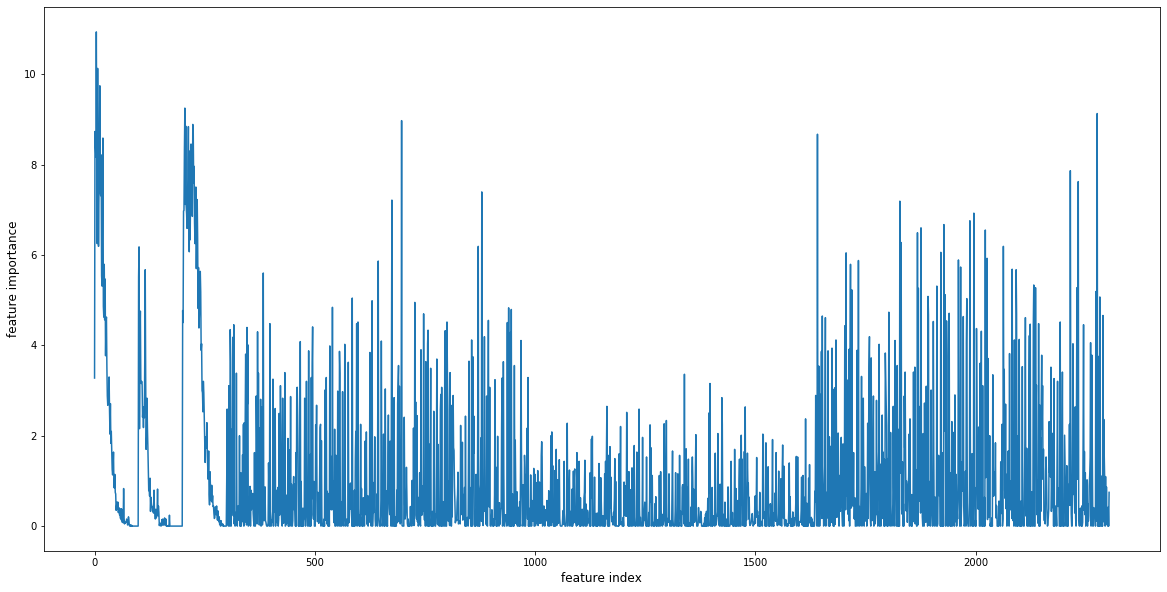

In [38]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('pkr_full_bm_fis.png', dpi=100)

In [40]:
plt.close()

## Adversarial controls

In [41]:
# View current training set
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0,0.000000,0,1.093288,0.0,1,0,0.0,1,5.749512
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


### Shuffle inputs, leaving outputs the same (shuffle inputs)
Trains model on fake reactions, testing on same test set of real ones

In [78]:
# Shuffle row ordering removing index
X_train_shuffle = np.random.permutation(X_train.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_shuffle_inputs = pd.DataFrame(
    X_train_shuffle, index=X_train.index, columns=X_train.columns
)

# View new dataframe (can see inputs have changed)
X_train_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,67.0,67.0,67.0,78.0,61.0,67.0,61.0,78.0,67.0,49.0,...,1.0,0.000000,0.0,0.477642,0.000000,0.0,0.0,0.00000,0.0,0.000000
1,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,67.0,67.0,...,1.0,0.000000,0.0,0.570794,0.000000,0.0,0.0,0.00000,0.0,0.000000
2,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,35.0,...,0.0,0.000000,0.0,0.764082,0.000000,0.0,0.0,0.00000,0.0,33.380709
3,67.0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,40.0,...,0.0,0.000000,0.0,0.952018,0.000000,0.0,0.0,0.00000,0.0,0.000000
4,67.0,67.0,67.0,67.0,67.0,67.0,49.0,40.0,67.0,67.0,...,1.0,26.660619,0.0,0.515193,0.000000,0.0,0.0,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,91.0,83.0,105.0,93.0,40.0,67.0,41.0,40.0,67.0,...,1.0,0.000000,0.0,0.146259,0.000000,0.0,0.0,5.90718,0.0,0.000000
2682,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,91.0,83.0,...,0.0,0.000000,0.0,0.734830,0.000000,0.0,0.0,0.00000,0.0,0.000000
2683,67.0,67.0,40.0,67.0,78.0,40.0,67.0,67.0,61.0,67.0,...,1.0,29.120476,1.0,1.205986,0.288675,0.0,0.0,0.00000,0.0,0.000000
2684,70.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,67.0,...,0.0,0.000000,0.0,0.170703,0.000000,0.0,0.0,0.00000,0.0,0.000000


In [43]:
# But indices have stayed the same
X_train_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [44]:
X_train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [45]:
# Re-train and test model
start_time = time.time()
shuffle_inputs_file = 'shuffle_inputs_bm_gbm.model.joblib'
shuffle_inputs_bm_gbm = train_lgbm_classifier(
    X_train_shuffle_inputs, y_train, shuffle_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_inputs_bm_preds = shuffle_inputs_bm_gbm.predict_proba(X_test)

# Get top-k predicted rankings from prediction set
suffle_inputs_bm_preds_labeled = get_top_k_preds(
    shuffle_inputs_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_inputs_bm_formatted_results = format_results_for_metrics(
    suffle_inputs_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_inputs_bm_metrics = get_metrics_dict(
    shuffle_inputs_bm_formatted_results, type_count, 
    'shuffle_inputs_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_inputs_top_1_acc = shuffle_inputs_bm_metrics['top_1_acc']
shuffle_inputs_top_3_acc = shuffle_inputs_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 434.240195274353 s
Top 1 accuracy for type  M  : 0.3969465648854962
Top 3 accuracy for type  M  : 0.767175572519084
Top 1 accuracy for type  L  : 0.8740458015267175
Top 3 accuracy for type  L  : 0.9732824427480916
Top 1 accuracy for type  S  : 0.2862595419847328
Top 3 accuracy for type  S  : 0.6412213740458015
Top 1 accuracy for type  A  : 0.6412213740458015
Top 3 accuracy for type  A  : 0.8854961832061069
Top 1 accuracy for type  T  : 0.29389312977099236
Top 3 accuracy for type  T  : 0.6030534351145038
Top 1 accuracy for type  P  : 0.8282442748091603
Top 3 accuracy for type  P  : 0.9694656488549618
Top 1 accuracy for type  G  : 0.5572519083969466
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8893129770992366
Top 3 accuracy for type  O  : 0.9274809160305344
Top 1 accuracy for type  N  : 0.7900763358778626
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [54]:
num_estimators = len(shuffle_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_inputs_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('pkr_shuffle_inputs_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['223', 'product_JGI5', 'product_EState_VSA3', '229', '217', '12', '228',
       '227', '231', 'product_JGI3', 'product_JGI4', '221', 'product_ATSC8d',
       '7', '224', 'product_JGI6', 'product_JGI8', '226', '216', '213'],
      dtype='object')
Index(['223', '229', '217', '12', '228', '227', '231', '221', '7', '224',
       '226', '216', '213', '235', '222', '6', '209', '14', '215', '232'],
      dtype='object')
Index(['product_JGI5', 'product_EState_VSA3', 'product_JGI3', 'product_JGI4',
       'product_ATSC8d', 'product_JGI6', 'product_JGI8', 'product_ATSC8i',
       'product_JGI7', 'product_ATSC3d', 'product_ATSC3dv', 'product_ATSC7se',
       'product_SdssC', 'product_SsssCH', 'product_ATSC7dv', 'product_ATSC2d',
       'product_PEOE_VSA8', 'product_ATSC4d', 'product_PEOE_VSA7',
       'product_ATSC7v'],
      dtype='object')


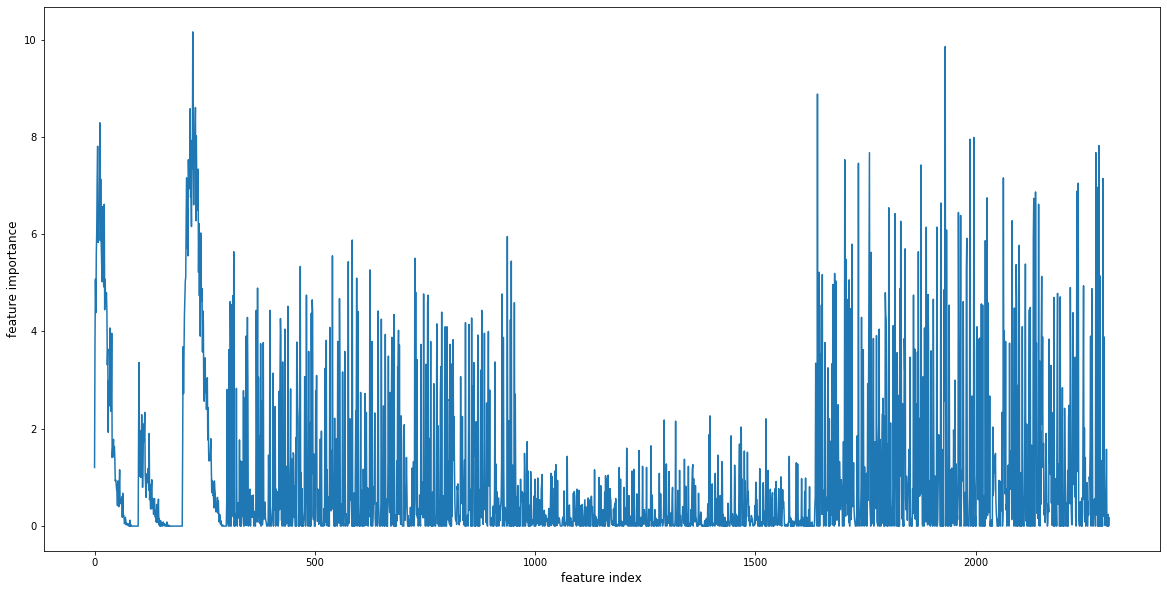

In [55]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('pkr_shuffle_inputs_bm_fis.png', dpi=100)

In [56]:
plt.close()

### Ablate SMILES region (Mordred only)

In [81]:
# Create new dataframe from only the Mordred input region
X_train_mordred = X_train[X_train.columns[300:]].copy()
X_test_mordred = X_test[X_test.columns[300:]].copy()
print(X_test_mordred.shape)

# View new dataframe (can see inputs have changed)
X_train_mordred

(262, 2004)


,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,12,148.747637,4.582413,0,0,6.606882,9459.193606,0,0.674143,-0.510431,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,3,34.436554,3.218876,0,0,0.000000,2366.901709,0,1.066667,0.286272,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,6,-48.292258,1.945910,0,0,0.000000,3106.572317,0,0.671310,-0.401455,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,10,4.595154,4.385147,0,0,17.919845,8581.113610,0,1.874025,-0.171871,...,0,0.000000,0,1.093288,0.0,1,0,0.0,1,5.749512
2682,16,455.848951,5.086052,0,0,6.606882,14501.420591,0,1.789804,2.403189,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,9,96.971724,4.356709,0,0,30.092446,9204.537626,0,0.886479,0.189568,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,10,321.858388,4.480174,0,0,6.606882,9825.206836,0,2.128732,5.816695,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


In [50]:
# Re-train and test model
start_time = time.time()
mordred_only_file = 'mordred_only_bm_gbm.model.joblib'
mordred_only_bm_gbm = train_lgbm_classifier(
    X_train_mordred, y_train, mordred_only_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_only_preds = mordred_only_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
mordred_only_preds_labeled = get_top_k_preds(
    mordred_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_only_formatted_results = format_results_for_metrics(
    mordred_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
mordred_only_metrics = get_metrics_dict(
    mordred_only_formatted_results, type_count, 'mordred_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_only_top_1_acc = mordred_only_metrics['top_1_acc']
mordred_only_top_3_acc = mordred_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 378.0950789451599 s
Top 1 accuracy for type  M  : 0.7404580152671756
Top 3 accuracy for type  M  : 0.9045801526717557
Top 1 accuracy for type  L  : 0.916030534351145
Top 3 accuracy for type  L  : 0.9885496183206107
Top 1 accuracy for type  S  : 0.5687022900763359
Top 3 accuracy for type  S  : 0.7977099236641222
Top 1 accuracy for type  A  : 0.7633587786259542
Top 3 accuracy for type  A  : 0.9351145038167938
Top 1 accuracy for type  T  : 0.46946564885496184
Top 3 accuracy for type  T  : 0.7862595419847328
Top 1 accuracy for type  P  : 0.8587786259541985
Top 3 accuracy for type  P  : 0.9847328244274809
Top 1 accuracy for type  G  : 0.8816793893129771
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8931297709923665
Top 3 accuracy for type  O  : 0.9732824427480916
Top 1 accuracy for type  N  : 0.8473282442748091
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [57]:
num_estimators = len(mordred_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
mordred_only_average_fis = np.average(np.array(all_fis), axis=0)
sorted_mordred_only_fis = np.argsort(-mordred_only_average_fis)
mordred_only_fi_names = X_train_mordred.columns[sorted_mordred_only_fis]

mordred_only_fi_df = pd.DataFrame(
    list(zip(mordred_only_fi_names, 
             mordred_only_average_fis[sorted_mordred_only_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_only_fi_df.to_csv('pkr_mordred_only_fis.csv')

top_mordred_only_fis = sorted_mordred_only_fis[:20]

top_mordred_only_fi_names = X_train_mordred.columns[top_mordred_only_fis]

print(top_mordred_only_fi_names)

Index(['product_SdsCH', 'product_EState_VSA3', 'rdfred_1_SddC', 'product_JGI4',
       'product_SdssC', 'product_SsssCH', 'product_JGI3', 'rdfred_2_Diameter',
       'product_JGI6', 'product_JGI5', 'product_Xch-5dv', 'product_ATSC4dv',
       'product_PEOE_VSA8', 'product_PEOE_VSA7', 'product_Xch-6dv',
       'product_JGI2', 'product_ATSC6dv', 'product_SssCH2', 'product_ATSC4v',
       'product_ATSC7se'],
      dtype='object')


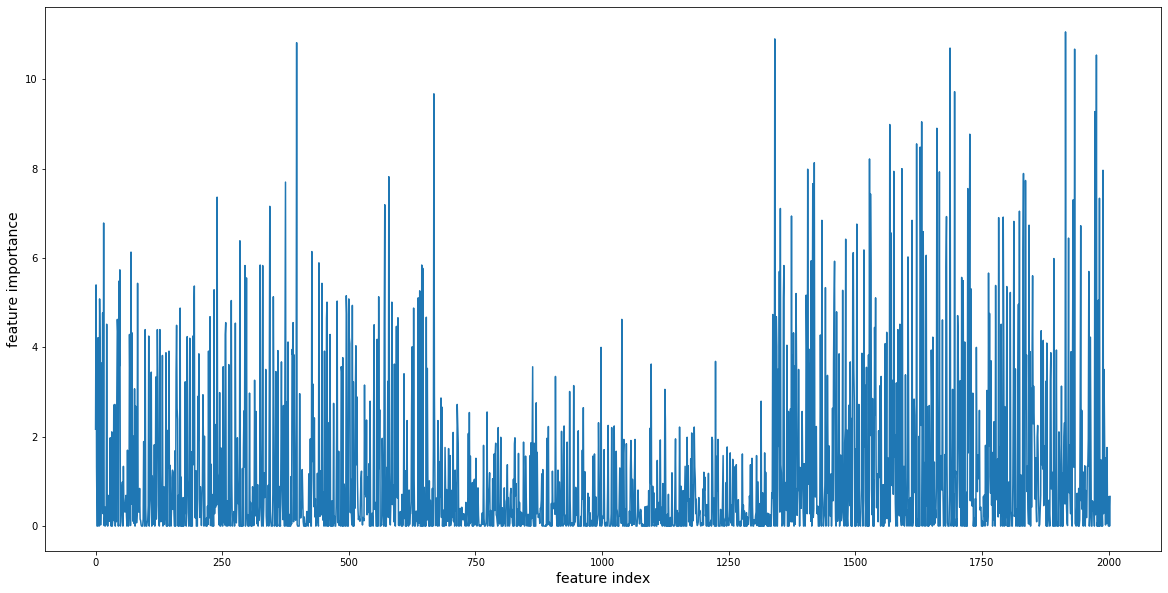

In [58]:
plt.figure(num=None, figsize=(20,10))
plt.plot(mordred_only_average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_mordred_only_bm_fis.png', dpi=100)

In [59]:
plt.close()

## Randomized Mordred vectors (random Mordred)
A random "barcode" is written for each unique molecule's Mordred vector drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [60]:
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,12,148.747637,4.582413,0,0,6.606882,9459.193606,0,0.674143,-0.510431,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,3,34.436554,3.218876,0,0,0.000000,2366.901709,0,1.066667,0.286272,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,6,-48.292258,1.945910,0,0,0.000000,3106.572317,0,0.671310,-0.401455,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,10,4.595154,4.385147,0,0,17.919845,8581.113610,0,1.874025,-0.171871,...,0,0.000000,0,1.093288,0.0,1,0,0.0,1,5.749512
2682,16,455.848951,5.086052,0,0,6.606882,14501.420591,0,1.789804,2.403189,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,9,96.971724,4.356709,0,0,30.092446,9204.537626,0,0.886479,0.189568,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,10,321.858388,4.480174,0,0,6.606882,9825.206836,0,2.128732,5.816695,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


In [68]:
X_train_mordred['rdfred_2_Diameter']

0       7.0
1       5.0
2       5.0
3       3.0
4       3.0
       ... 
2680    NaN
2682    NaN
2683    NaN
2684    NaN
2685    NaN
Name: rdfred_2_Diameter, Length: 2347, dtype: float64

In [148]:
mordred_max = X_full_mordred.max().max()
mordred_max

98541.53446692324

In [87]:
# Get all unique Mordred vectors from dataset
# Separate molecules
X_full_mordred = pd.DataFrame(
    X_full[X_full.columns[300:]].copy().values, 
    index=X_full.index.values
)
reactant_1_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[:668]].copy().values, 
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[668:1336]].copy().values, 
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[1336:]].copy().values, 
    index=X_full.index.values
)

# Join tabulated vectors to single lists
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred],
    ignore_index=True
)
print(f'Total Mordred vectors: {len(unique_mordred)}')
unique_mordred = unique_mordred.drop_duplicates(subset=['str_joined'])
print(f'Unique Mordred vectors: {len(unique_mordred)}')

# Create random fake vector representations for all unique molecules
unique_mordred['random'] = [
    (np.random.rand(668)*mordred_max).tolist() 
    for _ in range(len(unique_mordred))
]
unique_mordred['str_random'] = unique_mordred['random'].astype('str')
unique_mordred

Total Mordred vectors: 7827
Unique Mordred vectors: 3405


,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,random,str_random
0,12.0,1.487476e+02,4.582413,0.0,0.0,6.606882,9459.193606,0.0,6.741430e-01,-5.104313e-01,...,0.0,1.0,0.0,5.787111,1.0,11.840869,"[12.0, 148.74763689169745, 4.582413198865474, ...","[12.0, 148.74763689169745, 4.582413198865474, ...","[77785.95112338784, 69438.37490535637, 96048.6...","[77785.95112338784, 69438.37490535637, 96048.6..."
1,3.0,4.189135e+01,2.995732,0.0,0.0,0.000000,2736.737013,0.0,1.058824e+00,3.482437e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 41.89135259515576, 2.995732273553992, 0....","[3.0, 41.89135259515576, 2.995732273553992, 0....","[12570.875747372756, 23196.62576512857, 24811....","[12570.875747372756, 23196.62576512857, 24811...."
2,3.0,3.443655e+01,3.218876,0.0,0.0,0.000000,2366.901709,0.0,1.066667e+00,2.862718e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 34.43655367111133, 3.218875824868201, 0....","[3.0, 34.43655367111133, 3.218875824868201, 0....","[46813.36794078227, 39747.91141051661, 77330.0...","[46813.36794078227, 39747.91141051661, 77330.0..."
4,6.0,-4.829226e+01,1.945910,0.0,0.0,0.000000,3106.572317,0.0,6.713099e-01,-4.014546e-01,...,0.0,0.0,0.0,0.000000,0.0,12.343784,"[6.0, -48.292258437673, 1.9459101490553128, 0....","[6.0, -48.292258437673, 1.9459101490553128, 0....","[27307.77494608015, 95811.97584005866, 15831.4...","[27307.77494608015, 95811.97584005866, 15831.4..."
5,6.0,1.030287e-13,3.669951,0.0,0.0,5.563451,2242.497069,0.0,-1.332268e-15,5.551115e-16,...,0.0,0.0,0.0,0.000000,0.0,12.343784,"[6.0, 1.0302869668521453e-13, 3.66995144422841...","[6.0, 1.0302869668521453e-13, 3.66995144422841...","[35191.38724146613, 15370.999608559188, 64909....","[35191.38724146613, 15370.999608559188, 64909...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,9.0,3.510985e+02,4.789573,0.0,0.0,6.606882,10819.533423,0.0,1.979217e+00,6.892836e+00,...,0.0,1.0,0.0,0.000000,1.0,5.749512,"[9.0, 351.09853271819986, 4.78957290898587, 0....","[9.0, 351.09853271819986, 4.78957290898587, 0....","[12776.341182774964, 49872.1857024371, 24305.3...","[12776.341182774964, 49872.1857024371, 24305.3..."
7822,10.0,6.243953e+02,4.973280,0.0,0.0,12.204067,9531.434087,0.0,1.309474e+00,5.559038e+00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, 624.3953342700001, 4.973279507552487, 0...","[10.0, 624.3953342700001, 4.973279507552487, 0...","[85533.75737740469, 2160.3790476576446, 31758....","[85533.75737740469, 2160.3790476576446, 31758...."
7823,12.0,5.056775e+02,5.245707,0.0,0.0,6.606882,14813.666233,0.0,1.751314e+00,2.932106e+00,...,0.0,1.0,0.0,0.000000,1.0,5.749512,"[12.0, 505.67754008925886, 5.24570741627574, 0...","[12.0, 505.67754008925886, 5.24570741627574, 0...","[93863.39052016214, 76338.63065884881, 16661.3...","[93863.39052016214, 76338.63065884881, 16661.3..."
7824,9.0,1.559292e+02,4.672829,0.0,0.0,30.092446,9516.783268,0.0,8.564292e-01,8.735431e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[9.0, 155.92917214593473, 4.672828834461906, 0...","[9.0, 155.92917214593473, 4.672828834461906, 0...","[12405.546319474835, 90731.18871836708, 2118.5...","[12405.546319474835, 90731.18871836708, 2118.5..."


In [91]:
# Create mapping from true vectors to random vectors
mordred_random_dict = dict(zip(unique_mordred['str_joined'], unique_mordred['str_random']))
len(mordred_random_dict)

3405

In [92]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['str_random'] = df['str_joined'].map(mordred_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,12.0,148.747637,4.582413,0.0,0.0,6.606882,9459.193606,0.0,0.674143,-0.510431,...,0.0,1.0,0.0,5.787111,1.0,11.840869,"[12.0, 148.74763689169745, 4.582413198865474, ...","[12.0, 148.74763689169745, 4.582413198865474, ...","[77785.95112338784, 69438.37490535637, 96048.6...","[77785.95112338784, 69438.37490535637, 96048.6..."
1,3.0,41.891353,2.995732,0.0,0.0,0.000000,2736.737013,0.0,1.058824,0.348244,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 41.89135259515576, 2.995732273553992, 0....","[3.0, 41.89135259515576, 2.995732273553992, 0....","[12570.875747372756, 23196.62576512857, 24811....","[12570.875747372756, 23196.62576512857, 24811...."
2,3.0,34.436554,3.218876,0.0,0.0,0.000000,2366.901709,0.0,1.066667,0.286272,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 34.43655367111133, 3.218875824868201, 0....","[3.0, 34.43655367111133, 3.218875824868201, 0....","[46813.36794078227, 39747.91141051661, 77330.0...","[46813.36794078227, 39747.91141051661, 77330.0..."
3,3.0,41.891353,2.995732,0.0,0.0,0.000000,2736.737013,0.0,1.058824,0.348244,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 41.89135259515576, 2.995732273553992, 0....","[3.0, 41.89135259515576, 2.995732273553992, 0....","[12570.875747372756, 23196.62576512857, 24811....","[12570.875747372756, 23196.62576512857, 24811...."
4,6.0,-48.292258,1.945910,0.0,0.0,0.000000,3106.572317,0.0,0.671310,-0.401455,...,0.0,0.0,0.0,0.000000,0.0,12.343784,"[6.0, -48.292258437673, 1.9459101490553128, 0....","[6.0, -48.292258437673, 1.9459101490553128, 0....","[27307.77494608015, 95811.97584005866, 15831.4...","[27307.77494608015, 95811.97584005866, 15831.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,10.0,600.446536,4.783316,0.0,0.0,6.420822,9219.188445,0.0,1.320145,5.131720,...,0.0,0.0,0.0,0.000000,0.0,11.464143,"[10.0, 600.4465356254462, 4.7833163713715665, ...","[10.0, 600.4465356254462, 4.7833163713715665, ...","[34004.682239976835, 10791.316185376723, 59162...","[34004.682239976835, 10791.316185376723, 59162..."
2682,16.0,455.848951,5.086052,0.0,0.0,6.606882,14501.420591,0.0,1.789804,2.403189,...,0.0,0.0,0.0,0.000000,0.0,17.590380,"[16.0, 455.8489506426762, 5.08605193338101, 0....","[16.0, 455.8489506426762, 5.08605193338101, 0....","[65501.48063985855, 40376.29416398109, 8107.32...","[65501.48063985855, 40376.29416398109, 8107.32..."
2683,9.0,96.971724,4.356709,0.0,0.0,30.092446,9204.537626,0.0,0.886479,0.189568,...,0.0,0.0,0.0,0.000000,0.0,11.840869,"[9.0, 96.97172382886991, 4.356708826689592, 0....","[9.0, 96.97172382886991, 4.356708826689592, 0....","[43625.85253006321, 73156.92409475171, 41716.3...","[43625.85253006321, 73156.92409475171, 41716.3..."
2684,10.0,321.858388,4.480174,0.0,0.0,6.606882,9825.206836,0.0,2.128732,5.816695,...,0.0,0.0,0.0,0.000000,0.0,17.213655,"[10.0, 321.8583878688524, 4.480173695813406, 0...","[10.0, 321.8583878688524, 4.480173695813406, 0...","[73695.53566992072, 21709.87721394782, 39579.7...","[73695.53566992072, 21709.87721394782, 39579.7..."


In [93]:
reactant_2_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,7.0,8.171241e-14,3.876396,0.0,0.0,5.563451,2276.977528,0.0,0.266667,3.469447e-15,...,0.0,0.0,0.0,0.0,0.0,18.413006,"[7.0, 8.171241461241153e-14, 3.876395827784995...","[7.0, 8.171241461241153e-14, 3.876395827784995...","[22373.74054933448, 62406.76213461212, 92197.1...","[22373.74054933448, 62406.76213461212, 92197.1..."
1,5.0,1.634248e-13,3.548180,0.0,0.0,0.000000,2123.860761,0.0,0.339635,1.498801e-15,...,0.0,0.0,0.0,0.0,0.0,12.343784,"[5.0, 1.634248292248231e-13, 3.548179572010801...","[5.0, 1.634248292248231e-13, 3.548179572010801...","[87.3913792996006, 41648.89493861215, 71711.02...","[87.3913792996006, 41648.89493861215, 71711.02..."
2,5.0,1.634248e-13,3.548180,0.0,0.0,0.000000,2123.860761,0.0,0.339635,1.498801e-15,...,0.0,0.0,0.0,0.0,0.0,12.343784,"[5.0, 1.634248292248231e-13, 3.548179572010801...","[5.0, 1.634248292248231e-13, 3.548179572010801...","[87.3913792996006, 41648.89493861215, 71711.02...","[87.3913792996006, 41648.89493861215, 71711.02..."
3,3.0,3.443655e+01,3.218876,0.0,0.0,0.000000,2366.901709,0.0,1.066667,2.862718e-01,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[3.0, 34.43655367111133, 3.218875824868201, 0....","[3.0, 34.43655367111133, 3.218875824868201, 0....","[97623.13629969355, 96830.42189351107, 54774.2...","[97623.13629969355, 96830.42189351107, 54774.2..."
4,3.0,3.443655e+01,3.218876,0.0,0.0,0.000000,2366.901709,0.0,1.066667,2.862718e-01,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[3.0, 34.43655367111133, 3.218875824868201, 0....","[3.0, 34.43655367111133, 3.218875824868201, 0....","[97623.13629969355, 96830.42189351107, 54774.2...","[97623.13629969355, 96830.42189351107, 54774.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[28424.920646743445, 56573.65959678966, 87746....","[28424.920646743445, 56573.65959678966, 87746...."
2682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[28424.920646743445, 56573.65959678966, 87746....","[28424.920646743445, 56573.65959678966, 87746...."
2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[28424.920646743445, 56573.65959678966, 87746....","[28424.920646743445, 56573.65959678966, 87746...."
2684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[28424.920646743445, 56573.65959678966, 87746....","[28424.920646743445, 56573.65959678966, 87746...."


In [94]:
product_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,11.0,190.087026,4.857873,0.0,0.0,17.753091,9771.439248,0.0,0.717614,0.123429,...,0.0,1.0,0.0,0.0,1.0,0.000000,"[11.0, 190.08702582639125, 4.857872539543847, ...","[11.0, 190.08702582639125, 4.857872539543847, ...","[36284.39185572167, 49766.363171629746, 32760....","[36284.39185572167, 49766.363171629746, 32760...."
1,10.0,65.658482,4.524502,0.0,0.0,23.182509,5325.960183,0.0,0.411765,0.705342,...,0.0,0.0,0.0,0.0,0.0,6.069221,"[10.0, 65.6584819749134, 4.524502282920636, 0....","[10.0, 65.6584819749134, 4.524502282920636, 0....","[53991.710579235936, 25499.878981624377, 11766...","[53991.710579235936, 25499.878981624377, 11766..."
2,8.0,70.289915,4.427836,0.0,0.0,23.536963,4803.008112,0.0,0.346932,0.694260,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[8.0, 70.28991545057195, 4.427836170705175, 0....","[8.0, 70.28991545057195, 4.427836170705175, 0....","[9081.658750746074, 91439.58738354004, 53176.1...","[9081.658750746074, 91439.58738354004, 53176.1..."
3,8.0,81.555492,4.366278,0.0,0.0,23.536963,5172.843416,0.0,0.568330,0.788604,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[8.0, 81.55549201101914, 4.3662782777057405, 0...","[8.0, 81.55549201101914, 4.3662782777057405, 0...","[85039.81358595837, 10132.017968291042, 92674....","[85039.81358595837, 10132.017968291042, 92674...."
4,9.0,72.048008,4.025352,0.0,0.0,29.454869,5785.719668,0.0,0.520969,0.676164,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[9.0, 72.04800799999985, 4.02535169073515, 0.0...","[9.0, 72.04800799999985, 4.02535169073515, 0.0...","[85185.36064251943, 85935.07906286845, 12911.3...","[85185.36064251943, 85935.07906286845, 12911.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,10.0,624.395334,4.973280,0.0,0.0,12.204067,9531.434087,0.0,1.309474,5.559038,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[10.0, 624.3953342700001, 4.973279507552487, 0...","[10.0, 624.3953342700001, 4.973279507552487, 0...","[85533.75737740469, 2160.3790476576446, 31758....","[85533.75737740469, 2160.3790476576446, 31758...."
2682,12.0,505.677540,5.245707,0.0,0.0,6.606882,14813.666233,0.0,1.751314,2.932106,...,0.0,1.0,0.0,0.0,1.0,5.749512,"[12.0, 505.67754008925886, 5.24570741627574, 0...","[12.0, 505.67754008925886, 5.24570741627574, 0...","[93863.39052016214, 76338.63065884881, 16661.3...","[93863.39052016214, 76338.63065884881, 16661.3..."
2683,9.0,155.929172,4.672829,0.0,0.0,30.092446,9516.783268,0.0,0.856429,0.873543,...,0.0,0.0,0.0,0.0,0.0,0.000000,"[9.0, 155.92917214593473, 4.672828834461906, 0...","[9.0, 155.92917214593473, 4.672828834461906, 0...","[12405.546319474835, 90731.18871836708, 2118.5...","[12405.546319474835, 90731.18871836708, 2118.5..."
2684,8.0,359.861772,4.566949,0.0,0.0,6.606882,9825.206836,0.0,2.128732,6.111552,...,0.0,1.0,0.0,0.0,1.0,5.749512,"[8.0, 359.8617724740662, 4.566948973167893, 0....","[8.0, 359.8617724740662, 4.566948973167893, 0....","[36705.33389186675, 7457.947167391472, 1931.15...","[36705.33389186675, 7457.947167391472, 1931.15..."


In [95]:
reactant_1_mordred = pd.DataFrame(
    list(reactant_1_mordred['random'].values), 
    columns=X_full.columns[300:968],
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    list(reactant_2_mordred['random'].values), 
    columns=X_full.columns[968:1636],
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    list(product_mordred['random'].values), 
    columns=X_full.columns[1636:],
    index=X_full.index.values
)
reactant_1_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,rdfred_1_NsssN,rdfred_1_VSA_EState8,rdfred_1_n9FARing,rdfred_1_GGI6,rdfred_1_Xch-4d,rdfred_1_n7AHRing,rdfred_1_n10ARing,rdfred_1_PEOE_VSA13,rdfred_1_n7HRing,rdfred_1_SMR_VSA9
0,77785.951123,69438.374905,96048.677971,45218.758390,25822.878396,56499.680568,67772.566006,13678.299866,2345.643483,32267.780338,...,49812.289848,75120.715018,77307.142324,47131.240253,2867.573206,43745.867288,30085.886840,95554.013093,45853.079748,97266.538328
1,12570.875747,23196.625765,24811.211223,2483.457633,30823.126535,33764.944913,31950.013460,18561.574667,26106.917952,93716.540050,...,19902.071534,58376.794572,23531.792360,37628.828035,14735.829920,87077.858437,72796.732137,60448.110607,89795.920596,3717.914050
2,46813.367941,39747.911411,77330.060792,54504.514627,86416.793874,26216.234826,1231.639997,50214.299649,27652.281840,75937.059967,...,19488.536455,94328.212626,76576.684111,80918.068196,85948.566915,6342.397226,7331.638953,57733.885361,48930.641255,16824.519595
3,12570.875747,23196.625765,24811.211223,2483.457633,30823.126535,33764.944913,31950.013460,18561.574667,26106.917952,93716.540050,...,19902.071534,58376.794572,23531.792360,37628.828035,14735.829920,87077.858437,72796.732137,60448.110607,89795.920596,3717.914050
4,27307.774946,95811.975840,15831.418237,53425.386278,56308.264129,87555.365973,67204.118852,60924.340931,44999.243507,43927.562337,...,62620.797138,50115.917123,86029.451684,8987.756881,98091.222049,61944.784781,57671.630990,12900.210986,13805.835883,90189.564439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,34004.682240,10791.316185,59162.686224,44007.843377,17573.874516,73120.076222,76401.053592,53032.148792,64549.855996,41024.851881,...,3330.411092,78337.371681,94637.668616,22389.966663,71768.174851,25676.086789,31280.705129,426.422618,46341.460132,13240.101358
2682,65501.480640,40376.294164,8107.321209,84091.629888,10623.713949,76438.275178,92526.196610,97887.912338,51395.498315,30225.561814,...,89150.257668,18417.705522,29638.662945,46449.199219,42466.694157,36971.025796,1616.951311,27414.868205,49697.629086,79086.730861
2683,43625.852530,73156.924095,41716.317173,70265.405530,37580.399934,93326.911775,39070.870992,76865.395670,40237.697713,34738.718527,...,68477.769720,23631.005556,44331.828522,63867.706583,64632.397460,42795.928408,18636.648034,83981.387300,15146.633337,65776.736016
2684,73695.535670,21709.877214,39579.751051,75355.671239,25033.770595,46946.647277,7841.246695,61523.704280,42942.360843,66020.922337,...,43033.002014,58701.951822,21337.741777,783.248257,86784.524780,18673.149604,26729.046308,91333.908263,50523.166318,12413.950592


In [96]:
reactant_2_mordred

,rdfred_2_Diameter,rdfred_2_ATSC1m,rdfred_2_piPC3,rdfred_2_n5aHRing,rdfred_2_n4AHRing,rdfred_2_EState_VSA3,rdfred_2_ATS0i,rdfred_2_SaaSe,rdfred_2_CIC3,rdfred_2_ATSC1p,...,rdfred_2_NsssN,rdfred_2_VSA_EState8,rdfred_2_n9FARing,rdfred_2_GGI6,rdfred_2_Xch-4d,rdfred_2_n7AHRing,rdfred_2_n10ARing,rdfred_2_PEOE_VSA13,rdfred_2_n7HRing,rdfred_2_SMR_VSA9
0,22373.740549,62406.762135,92197.137569,3955.861615,44369.107548,71168.945292,75582.371968,39900.387972,8859.467652,44967.080237,...,10445.316524,25514.718909,72814.129949,51335.879525,59274.850427,72919.011645,12664.601683,54493.190057,35355.595258,19915.591860
1,87.391379,41648.894939,71711.024523,47650.980055,814.197635,63996.129326,41036.436092,95706.142565,93560.920604,53085.765218,...,61128.358349,39165.845838,84652.853833,60028.831991,69213.777543,57894.356932,17810.417428,53930.448667,80572.191507,51648.179772
2,87.391379,41648.894939,71711.024523,47650.980055,814.197635,63996.129326,41036.436092,95706.142565,93560.920604,53085.765218,...,61128.358349,39165.845838,84652.853833,60028.831991,69213.777543,57894.356932,17810.417428,53930.448667,80572.191507,51648.179772
3,97623.136300,96830.421894,54774.286942,90686.953857,44135.835136,42239.617359,20567.505874,8754.604500,52098.443402,36220.838813,...,6892.266226,40240.044473,47198.262801,60918.413114,96669.639042,33430.477845,45305.554608,29004.999238,23111.525800,48885.439212
4,97623.136300,96830.421894,54774.286942,90686.953857,44135.835136,42239.617359,20567.505874,8754.604500,52098.443402,36220.838813,...,6892.266226,40240.044473,47198.262801,60918.413114,96669.639042,33430.477845,45305.554608,29004.999238,23111.525800,48885.439212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,28424.920647,56573.659597,87746.588825,27692.300239,36745.886221,19724.525437,23786.065017,40545.424312,96397.729365,78187.417341,...,62254.816642,32906.908247,30474.447377,46925.171546,68470.885198,65679.525219,72953.070630,68590.046896,17333.437270,24835.567593
2682,28424.920647,56573.659597,87746.588825,27692.300239,36745.886221,19724.525437,23786.065017,40545.424312,96397.729365,78187.417341,...,62254.816642,32906.908247,30474.447377,46925.171546,68470.885198,65679.525219,72953.070630,68590.046896,17333.437270,24835.567593
2683,28424.920647,56573.659597,87746.588825,27692.300239,36745.886221,19724.525437,23786.065017,40545.424312,96397.729365,78187.417341,...,62254.816642,32906.908247,30474.447377,46925.171546,68470.885198,65679.525219,72953.070630,68590.046896,17333.437270,24835.567593
2684,28424.920647,56573.659597,87746.588825,27692.300239,36745.886221,19724.525437,23786.065017,40545.424312,96397.729365,78187.417341,...,62254.816642,32906.908247,30474.447377,46925.171546,68470.885198,65679.525219,72953.070630,68590.046896,17333.437270,24835.567593


In [97]:
product_mordred

,product_Diameter,product_ATSC1m,product_piPC3,product_n5aHRing,product_n4AHRing,product_EState_VSA3,product_ATS0i,product_SaaSe,product_CIC3,product_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,36284.391856,49766.363172,32760.084197,20591.941890,44583.771393,78029.171954,35471.634652,74887.138908,14868.814697,22642.954052,...,65896.745717,21783.792849,90571.847413,15291.794446,54431.749080,84963.454167,67394.218611,21900.689179,41838.985403,87138.695800
1,53991.710579,25499.878982,11766.613555,95965.324457,23463.189508,60609.460917,8665.960504,87274.641016,67426.959377,80686.688182,...,95469.496800,12270.742611,60509.173832,69898.547622,25294.579749,59245.572715,31562.254940,86068.170804,69612.983361,4937.408419
2,9081.658751,91439.587384,53176.198357,40493.557776,91792.419687,41591.808861,56506.342542,20750.684036,85369.277706,80565.447442,...,20183.349479,28114.399770,5834.468376,1883.315541,75105.389086,98100.663696,12622.826783,45342.852208,36986.530801,70518.526376
3,85039.813586,10132.017968,92674.968734,95270.918084,79419.017748,6710.658379,12785.113297,12291.330639,10551.663750,48714.545445,...,22853.240017,19021.345702,32563.385734,56316.077991,13665.376970,11462.129658,2226.777617,28523.405878,12932.115249,44550.922229
4,85185.360643,85935.079063,12911.339292,26202.539757,56671.505705,42330.225766,67201.479185,77016.344520,74803.162469,69187.477760,...,1440.742426,62512.695000,70904.947869,10492.272848,78949.361637,59930.811801,35726.355546,83267.226101,11291.650249,34905.382347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,85533.757377,2160.379048,31758.152214,89013.642208,95241.852069,93612.747274,69555.831028,55466.163647,48256.239034,73137.887301,...,7791.663749,38035.995578,82947.173516,97171.594797,90566.711529,9598.019542,60370.355484,67733.758554,82890.677149,58302.364927
2682,93863.390520,76338.630659,16661.338496,93534.724924,32384.992774,95251.443922,454.420046,11316.537839,41907.241336,94829.118345,...,98438.122419,388.973427,24023.551600,24762.293118,34101.512451,62727.492419,79420.169944,36004.778436,49291.214941,71981.687785
2683,12405.546319,90731.188718,2118.516276,37382.151710,55291.010006,71932.112720,37556.496543,22016.029670,89881.677267,87918.729704,...,87007.187648,92968.623724,1692.570206,11306.555689,68732.382127,81347.887831,47367.487686,43962.235110,34472.646075,76296.110693
2684,36705.333892,7457.947167,1931.156508,78786.913919,14998.453051,77822.323042,56792.971957,83712.916085,62100.178725,18134.953247,...,44281.101164,48196.719014,83814.301081,4453.932544,72435.959040,55613.213905,73056.965735,15270.443768,31161.551132,30746.842077


In [98]:
# Re-combine component molecules into full dataframe
X_full_random_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred], axis=1
)

# View new dataframe
X_full_random_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,77785.951123,69438.374905,96048.677971,45218.758390,25822.878396,56499.680568,67772.566006,13678.299866,2345.643483,32267.780338,...,65896.745717,21783.792849,90571.847413,15291.794446,54431.749080,84963.454167,67394.218611,21900.689179,41838.985403,87138.695800
1,12570.875747,23196.625765,24811.211223,2483.457633,30823.126535,33764.944913,31950.013460,18561.574667,26106.917952,93716.540050,...,95469.496800,12270.742611,60509.173832,69898.547622,25294.579749,59245.572715,31562.254940,86068.170804,69612.983361,4937.408419
2,46813.367941,39747.911411,77330.060792,54504.514627,86416.793874,26216.234826,1231.639997,50214.299649,27652.281840,75937.059967,...,20183.349479,28114.399770,5834.468376,1883.315541,75105.389086,98100.663696,12622.826783,45342.852208,36986.530801,70518.526376
3,12570.875747,23196.625765,24811.211223,2483.457633,30823.126535,33764.944913,31950.013460,18561.574667,26106.917952,93716.540050,...,22853.240017,19021.345702,32563.385734,56316.077991,13665.376970,11462.129658,2226.777617,28523.405878,12932.115249,44550.922229
4,27307.774946,95811.975840,15831.418237,53425.386278,56308.264129,87555.365973,67204.118852,60924.340931,44999.243507,43927.562337,...,1440.742426,62512.695000,70904.947869,10492.272848,78949.361637,59930.811801,35726.355546,83267.226101,11291.650249,34905.382347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,34004.682240,10791.316185,59162.686224,44007.843377,17573.874516,73120.076222,76401.053592,53032.148792,64549.855996,41024.851881,...,7791.663749,38035.995578,82947.173516,97171.594797,90566.711529,9598.019542,60370.355484,67733.758554,82890.677149,58302.364927
2682,65501.480640,40376.294164,8107.321209,84091.629888,10623.713949,76438.275178,92526.196610,97887.912338,51395.498315,30225.561814,...,98438.122419,388.973427,24023.551600,24762.293118,34101.512451,62727.492419,79420.169944,36004.778436,49291.214941,71981.687785
2683,43625.852530,73156.924095,41716.317173,70265.405530,37580.399934,93326.911775,39070.870992,76865.395670,40237.697713,34738.718527,...,87007.187648,92968.623724,1692.570206,11306.555689,68732.382127,81347.887831,47367.487686,43962.235110,34472.646075,76296.110693
2684,73695.535670,21709.877214,39579.751051,75355.671239,25033.770595,46946.647277,7841.246695,61523.704280,42942.360843,66020.922337,...,44281.101164,48196.719014,83814.301081,4453.932544,72435.959040,55613.213905,73056.965735,15270.443768,31161.551132,30746.842077


In [99]:
# Re-split full dataset based on test indices
X_train_random_mordred = X_full_random_mordred[
    ~X_full_random_mordred.index.isin(test_inds)
]
X_test_random_mordred = X_full_random_mordred[
    X_full_random_mordred.index.isin(test_inds)
]

# Check sets
print(X_train_random_mordred.shape, y_train.shape, 
      X_test_random_mordred.shape, y_test.shape)

(2347, 2004) (2347, 85) (262, 2004) (262, 85)


In [100]:
# Re-train and test model
start_time = time.time()
random_mordred_file = 'random_mordred_bm_gbm.model.joblib'
random_mordred_bm_gbm = train_lgbm_classifier(
    X_train_random_mordred, y_train, random_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_mordred_preds = random_mordred_bm_gbm.predict_proba(
    X_test_random_mordred
)

# Get top-k predicted rankings from prediction set
random_mordred_preds_labeled = get_top_k_preds(
    random_mordred_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_mordred_formatted_results = format_results_for_metrics(
    random_mordred_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_mordred_metrics = get_metrics_dict(
    random_mordred_formatted_results, type_count, 'random_mordred_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_mordred_top_1_acc = random_mordred_metrics['top_1_acc']
random_mordred_top_3_acc = random_mordred_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 541.181694984436 s
Top 1 accuracy for type  M  : 0.5763358778625954
Top 3 accuracy for type  M  : 0.8129770992366412
Top 1 accuracy for type  L  : 0.9007633587786259
Top 3 accuracy for type  L  : 0.9847328244274809
Top 1 accuracy for type  S  : 0.3893129770992366
Top 3 accuracy for type  S  : 0.7061068702290076
Top 1 accuracy for type  A  : 0.6755725190839694
Top 3 accuracy for type  A  : 0.8854961832061069
Top 1 accuracy for type  T  : 0.37404580152671757
Top 3 accuracy for type  T  : 0.6755725190839694
Top 1 accuracy for type  P  : 0.8244274809160306
Top 3 accuracy for type  P  : 0.9732824427480916
Top 1 accuracy for type  G  : 0.7061068702290076
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8854961832061069
Top 3 accuracy for type  O  : 0.9541984732824428
Top 1 accuracy for type  N  : 0.8206106870229007
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [101]:
num_estimators = len(random_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_mordred_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_random_mordred.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('pkr_random_mordred_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_random_mordred.columns[top_fis]

print(top_fi_names)

Index(['rdfred_1_Diameter', 'product_SsF', 'rdfred_2_CIC3',
       'rdfred_1_SlogP_VSA6', 'product_nSpiro', 'rdfred_1_TopoPSA(NO)',
       'rdfred_1_ATSC5m', 'product_ATSC7pe', 'product_n8ARing',
       'rdfred_1_SMR_VSA7', 'rdfred_2_nBondsS', 'product_n3AHRing',
       'rdfred_1_n6HRing', 'rdfred_1_n12FaHRing', 'product_C3SP2',
       'product_Xch-5dv', 'rdfred_1_ATSC3p', 'rdfred_1_ATS6v', 'product_ATS1m',
       'product_ATSC5dv'],
      dtype='object')


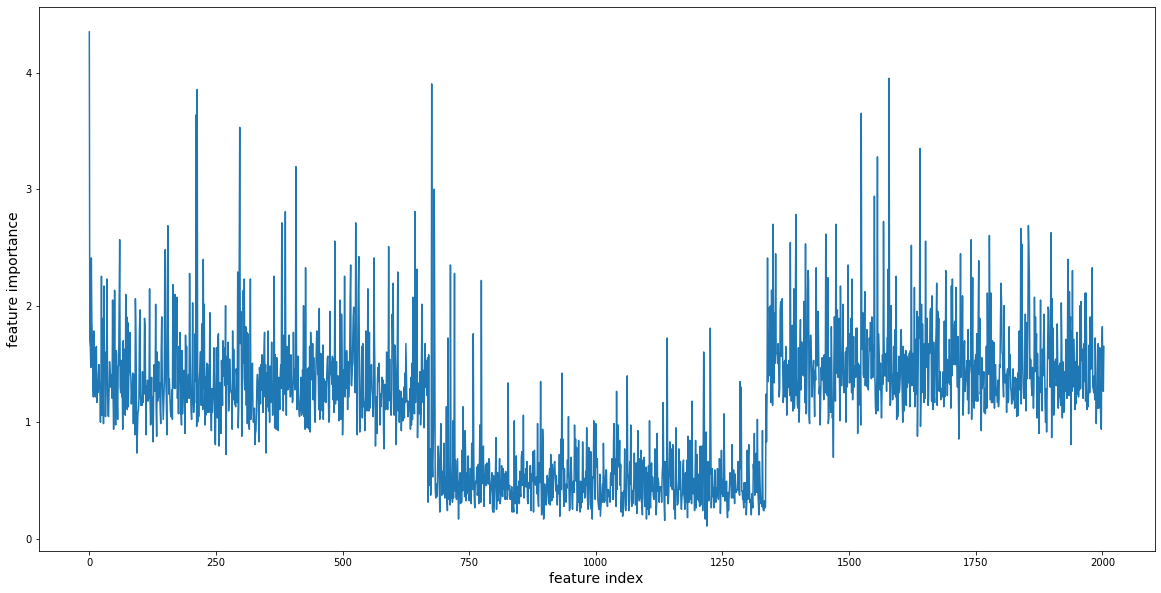

In [102]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_random_mordred_bm_fis.png', dpi=100)

In [103]:
plt.close()

### Shuffle Mordred vectors, leaving outputs the same (shuffle Mordred)
Trains model on fake reactions, testing on same test set of real ones

In [104]:
# Show Mordred dataset for comparison
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,12,148.747637,4.582413,0,0,6.606882,9459.193606,0,0.674143,-0.510431,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,3,34.436554,3.218876,0,0,0.000000,2366.901709,0,1.066667,0.286272,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,3,41.891353,2.995732,0,0,0.000000,2736.737013,0,1.058824,0.348244,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,6,-48.292258,1.945910,0,0,0.000000,3106.572317,0,0.671310,-0.401455,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,10,4.595154,4.385147,0,0,17.919845,8581.113610,0,1.874025,-0.171871,...,0,0.000000,0,1.093288,0.0,1,0,0.0,1,5.749512
2682,16,455.848951,5.086052,0,0,6.606882,14501.420591,0,1.789804,2.403189,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,9,96.971724,4.356709,0,0,30.092446,9204.537626,0,0.886479,0.189568,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,10,321.858388,4.480174,0,0,6.606882,9825.206836,0,2.128732,5.816695,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


In [105]:
# Shuffle row ordering removing index
X_train_mordred_shuffle = np.random.permutation(X_train_mordred.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_mordred_shuffle_inputs = pd.DataFrame(
    X_train_mordred_shuffle, index=X_train_mordred.index, 
    columns=X_train_mordred.columns
)

# View new dataframe (can see inputs have changed)
X_train_mordred_shuffle_inputs

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,7.0,1.284553e+01,2.890372,0.0,0.0,0.000000,4497.056620,0.0,1.482930,-1.703752e+00,...,1.0,0.00000,0.0,0.464535,0.0,0.0,0.0,0.000000,0.0,0.000000
1,9.0,3.805779e+01,3.886705,0.0,0.0,0.000000,4111.446669,0.0,0.336726,-9.197117e-01,...,0.0,0.00000,0.0,0.161633,0.0,0.0,0.0,0.000000,0.0,5.749512
2,3.0,4.189135e+01,2.995732,0.0,0.0,0.000000,2736.737013,0.0,1.058824,3.482437e-01,...,0.0,0.00000,0.0,0.212336,0.0,0.0,0.0,0.000000,0.0,0.000000
3,14.0,6.778290e+01,4.634729,0.0,0.0,0.000000,5765.000180,0.0,0.344727,8.948040e-01,...,0.0,0.00000,1.0,0.624671,0.0,0.0,0.0,5.687386,0.0,28.003318
4,11.0,1.832412e+01,3.984344,0.0,0.0,13.027704,4238.241025,0.0,0.398329,-4.428242e-01,...,0.0,0.00000,1.0,0.141224,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,15.0,4.530766e+02,4.731803,0.0,0.0,12.965578,12346.292579,0.0,1.146802,1.773245e+00,...,1.0,6.49277,0.0,1.355147,0.0,0.0,0.0,0.000000,0.0,0.000000
2682,13.0,2.830464e+02,4.273188,0.0,0.0,0.000000,7283.401605,0.0,1.044328,5.594495e+00,...,0.0,0.00000,0.0,0.534830,0.0,0.0,0.0,0.000000,0.0,0.000000
2683,7.0,-4.263256e-14,3.630985,0.0,0.0,0.000000,2805.941707,0.0,0.375272,1.887379e-15,...,0.0,0.00000,0.0,0.324898,0.0,0.0,0.0,0.000000,0.0,0.000000
2684,6.0,-5.454499e+01,3.135494,0.0,0.0,0.000000,3545.612315,0.0,0.886808,1.739618e-02,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [106]:
# But indices have stayed the same
X_train_mordred_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [107]:
X_train_mordred.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [108]:
# Check test set
X_test_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
15,6,1.530549e+01,3.583519,0,0,0.000000,4725.390189,0,1.017578,-1.413451e+00,...,0,0.000000,0,0.364082,0.0,0,0,0.00000,0,0.000000
26,5,1.634248e-13,3.548180,0,0,0.000000,2123.860761,0,0.339635,1.498801e-15,...,0,0.000000,0,0.444082,0.0,0,0,0.00000,0,33.380709
27,7,-2.025047e-13,3.876396,0,0,5.563451,2932.736063,0,0.250257,1.498801e-15,...,0,0.000000,0,0.927347,0.0,0,0,0.00000,0,33.380709
36,7,3.699921e+01,3.936716,0,0,11.499024,3488.022653,0,0.886808,-9.286077e-01,...,0,0.000000,0,0.990204,0.0,0,0,0.00000,0,67.877780
46,11,3.018726e+02,4.791650,0,0,5.563451,9989.938634,0,1.020695,4.853958e+00,...,1,0.000000,1,1.843492,0.0,0,0,5.90718,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,9,2.544853e+01,4.445588,0,0,12.524788,9388.921645,0,2.014364,-5.234495e-01,...,0,0.000000,0,1.395828,0.0,0,0,0.00000,0,5.749512
2667,10,5.674989e+01,4.731803,0,0,5.573105,7102.839662,0,0.911546,-6.344165e-01,...,0,0.000000,0,1.054875,0.0,0,0,0.00000,0,0.000000
2678,11,7.100889e+02,4.665795,0,0,6.606882,13923.350933,0,2.132576,8.154398e+00,...,0,7.392053,0,2.695011,0.0,1,0,0.00000,1,5.749512
2679,13,3.624656e+01,4.762174,0,0,6.606882,10081.550355,0,1.652035,2.067793e-01,...,0,0.000000,0,1.013288,0.0,1,0,0.00000,1,5.749512


In [109]:
# Re-train and test model
start_time = time.time()
shuffle_mordred_file = 'shuffle_mordred_bm_gbm.model.joblib'
shuffle_mordred_bm_gbm = train_lgbm_classifier(
    X_train_mordred_shuffle_inputs, y_train, shuffle_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_mordred_bm_preds = shuffle_mordred_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
shuffle_mordred_bm_preds_labeled = get_top_k_preds(
    shuffle_mordred_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_mordred_bm_formatted_results = format_results_for_metrics(
    shuffle_mordred_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_mordred_bm_metrics = get_metrics_dict(
    shuffle_mordred_bm_formatted_results, type_count, 
    'shuffle_mordred_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_mordred_top_1_acc = shuffle_mordred_bm_metrics['top_1_acc']
shuffle_mordred_top_3_acc = shuffle_mordred_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 411.5928580760956 s
Top 1 accuracy for type  M  : 0.33587786259541985
Top 3 accuracy for type  M  : 0.7480916030534351
Top 1 accuracy for type  L  : 0.8625954198473282
Top 3 accuracy for type  L  : 0.9694656488549618
Top 1 accuracy for type  S  : 0.2366412213740458
Top 3 accuracy for type  S  : 0.5992366412213741
Top 1 accuracy for type  A  : 0.6374045801526718
Top 3 accuracy for type  A  : 0.8778625954198473
Top 1 accuracy for type  T  : 0.2480916030534351
Top 3 accuracy for type  T  : 0.6221374045801527
Top 1 accuracy for type  P  : 0.816793893129771
Top 3 accuracy for type  P  : 0.9694656488549618
Top 1 accuracy for type  G  : 0.5114503816793893
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8702290076335878
Top 3 accuracy for type  O  : 0.9312977099236641
Top 1 accuracy for type  N  : 0.7900763358778626
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [110]:
num_estimators = len(shuffle_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_mordred_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_mordred_shuffle_inputs.columns[top_fis]

print(top_fi_names)

Index(['product_PEOE_VSA7', 'product_ATSC2d', 'product_JGI6', 'product_JGI5',
       'product_JGI4', 'product_ATSC3se', 'product_ATSC4i', 'product_JGI3',
       'product_ATSC3d', 'product_PEOE_VSA8', 'product_ATSC4dv',
       'product_ATSC7i', 'product_ATSC4p', 'product_EState_VSA4',
       'product_EState_VSA3', 'product_ATSC4se', 'product_SdsCH',
       'product_ATSC4v', 'product_SsssCH', 'product_ATSC6p'],
      dtype='object')


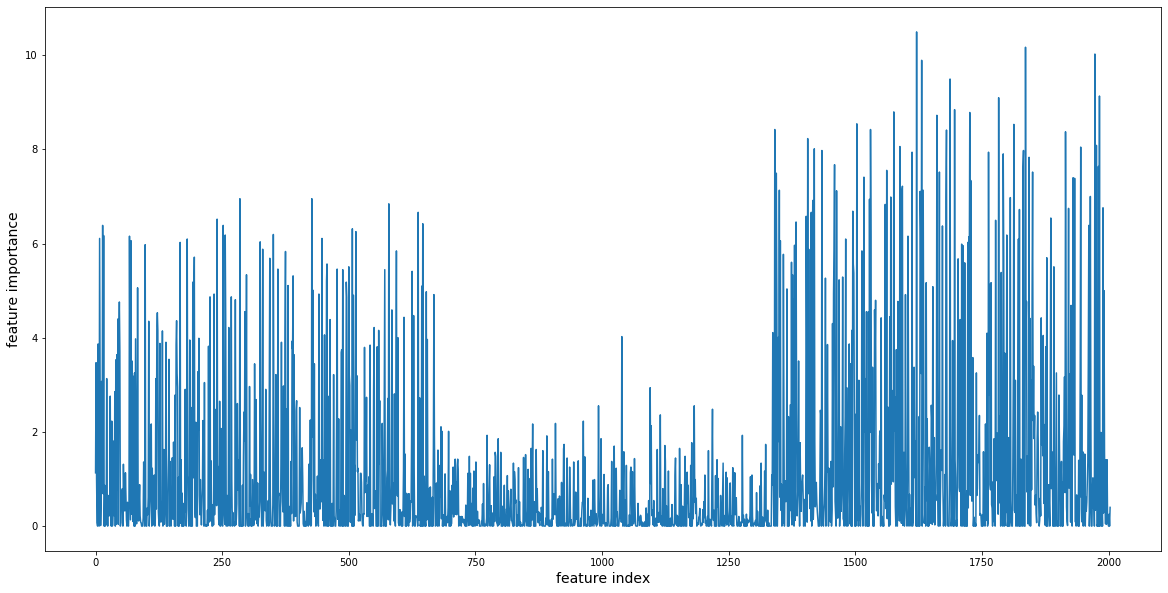

In [111]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_shuffle_mordred_bm_fis.png', dpi=100)

In [112]:
plt.close()

### Ablate Mordred region (SMILES only)

In [113]:
# Create new dataframe from only the Mordred input region
X_train_smiles = X_train[X_train.columns[:300]].copy()
X_test_smiles = X_test[X_test.columns[:300]].copy()
print(X_test_smiles.shape)

# View new dataframe (can see inputs have changed)
X_train_smiles

(262, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# Re-train and test model
start_time = time.time()
smiles_only_file = 'smiles_only_bm_gbm.model.joblib'
smiles_only_bm_gbm = train_lgbm_classifier(X_train_smiles, y_train, smiles_only_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
smiles_only_preds = smiles_only_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
smiles_only_preds_labeled = get_top_k_preds(
    smiles_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
smiles_only_formatted_results = format_results_for_metrics(
    smiles_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
smiles_only_metrics = get_metrics_dict(
    smiles_only_formatted_results, type_count, 'smiles_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
smiles_only_top_1_acc = smiles_only_metrics['top_1_acc']
smiles_only_top_3_acc = smiles_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 19.104710817337036 s
Top 1 accuracy for type  M  : 0.6183206106870229
Top 3 accuracy for type  M  : 0.8587786259541985
Top 1 accuracy for type  L  : 0.8969465648854962
Top 3 accuracy for type  L  : 0.9885496183206107
Top 1 accuracy for type  S  : 0.6183206106870229
Top 3 accuracy for type  S  : 0.8625954198473282
Top 1 accuracy for type  A  : 0.8053435114503816
Top 3 accuracy for type  A  : 0.9618320610687023
Top 1 accuracy for type  T  : 0.5687022900763359
Top 3 accuracy for type  T  : 0.8358778625954199
Top 1 accuracy for type  P  : 0.8587786259541985
Top 3 accuracy for type  P  : 0.9770992366412213
Top 1 accuracy for type  G  : 0.7938931297709924
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8854961832061069
Top 3 accuracy for type  O  : 0.9656488549618321
Top 1 accuracy for type  N  : 0.8396946564885496
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [115]:
num_estimators = len(smiles_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(smiles_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_smiles.columns[top_fis]

print(top_fi_names)

Index(['213', '7', '221', '5', '214', '226', '225', '11', '4', '219', '224',
       '10', '6', '13', '220', '205', '211', '222', '12', '212'],
      dtype='object')


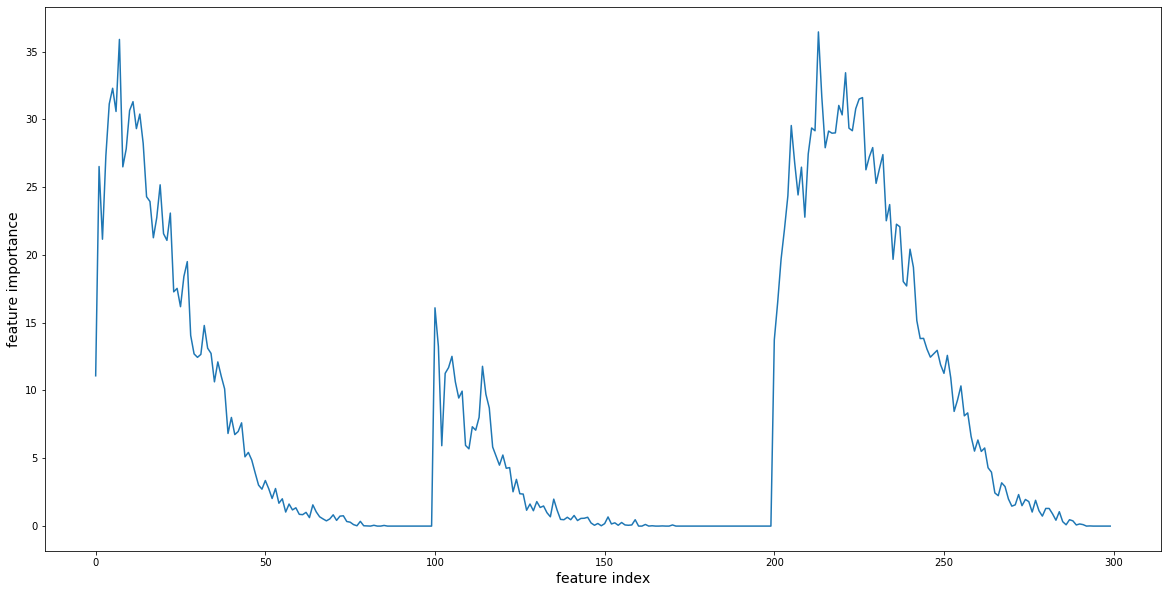

In [116]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_smiles_only_bm_fis.png', dpi=100)

In [117]:
plt.close()

### Randomized SMILES representations (random SMILES)
A random "barcode" is written for each unique molecule's SMILES drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [118]:
# Get all unique tokenized SMILES from dataset
# Separate molecules
reactant_1_smiles = pd.DataFrame(
    X_full[X_full.columns[:100]].copy().values, index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    X_full[X_full.columns[100:200]].copy().values, index=X_full.index.values
)
product_smiles = pd.DataFrame(
    X_full[X_full.columns[200:300]].copy().values, index=X_full.index.values
)

# Join tabulated SMILES to single lists
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], ignore_index=True
)
print(f'Total SMILES: {len(unique_smiles)}')
unique_smiles = unique_smiles.drop_duplicates(subset=['str_joined'])
print(f'Unique SMILES: {len(unique_smiles)}')

# Create random fake SMILES representations for all unique molecules
unique_smiles['random'] = [
    np.random.randint(115, size=100).tolist() 
    for _ in range(len(unique_smiles))
]
unique_smiles['str_random'] = unique_smiles['random'].astype('str')
unique_smiles

Total SMILES: 7827
Unique SMILES: 3448


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,random,str_random
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[5, 85, 53, 5, 18, 48, 42, 70, 8, 10, 93, 69, ...","[5, 85, 53, 5, 18, 48, 42, 70, 8, 10, 93, 69, ..."
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,...","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,..."
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ...","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ..."
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 35.0, 67....","[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 35.0, 67....","[74, 0, 18, 57, 114, 28, 95, 33, 104, 21, 62, ...","[74, 0, 18, 57, 114, 28, 95, 33, 104, 21, 62, ..."
5,70.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[70.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[70.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[70, 43, 88, 102, 112, 4, 7, 49, 74, 88, 69, 6...","[70, 43, 88, 102, 112, 4, 7, 49, 74, 88, 69, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,79.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[80, 75, 76, 47, 95, 89, 98, 13, 33, 22, 13, 8...","[80, 75, 76, 47, 95, 89, 98, 13, 33, 22, 13, 8..."
7823,79.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,93.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[62, 105, 44, 48, 42, 26, 36, 83, 74, 49, 88, ...","[62, 105, 44, 48, 42, 26, 36, 83, 74, 49, 88, ..."
7824,79.0,61.0,67.0,49.0,67.0,67.0,50.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[77, 19, 44, 83, 47, 97, 33, 86, 85, 98, 13, 3...","[77, 19, 44, 83, 47, 97, 33, 86, 85, 98, 13, 3..."
7825,79.0,61.0,67.0,49.0,67.0,67.0,50.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[70, 14, 59, 77, 6, 64, 85, 80, 110, 103, 43, ...","[70, 14, 59, 77, 6, 64, 85, 80, 110, 103, 43, ..."


In [119]:
# Create mapping from true SMILES to ranom SMILES
smiles_random_dict = dict(zip(unique_smiles['str_joined'], unique_smiles['str_random']))
len(smiles_random_dict)

3448

In [120]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['str_random'] = df['str_joined'].map(smiles_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[5, 85, 53, 5, 18, 48, 42, 70, 8, 10, 93, 69, ...","[5, 85, 53, 5, 18, 48, 42, 70, 8, 10, 93, 69, ..."
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,...","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,..."
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ...","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ..."
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[67.0, 49.0, 67.0, 67.0, 50.0, 67.0, 67.0, 49....","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,...","[92, 25, 36, 51, 90, 38, 71, 60, 113, 114, 49,..."
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 35.0, 67....","[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 35.0, 67....","[74, 0, 18, 57, 114, 28, 95, 33, 104, 21, 62, ...","[74, 0, 18, 57, 114, 28, 95, 33, 104, 21, 62, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,93.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[67.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[20, 96, 23, 87, 88, 21, 32, 38, 32, 61, 107, ...","[20, 96, 23, 87, 88, 21, 32, 38, 32, 61, 107, ..."
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[67.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[19, 19, 13, 63, 104, 57, 76, 65, 35, 34, 111,...","[19, 19, 13, 63, 104, 57, 76, 65, 35, 34, 111,..."
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 61.0, 67.0, 49.0, 67.0, 67.0, 67.0, 67....","[67.0, 61.0, 67.0, 49.0, 67.0, 67.0, 67.0, 67....","[33, 72, 1, 92, 46, 109, 97, 48, 57, 24, 81, 1...","[33, 72, 1, 92, 46, 109, 97, 48, 57, 24, 81, 1..."
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 61.0, 67.0, 49.0, 67.0, 67.0, 67.0, 67....","[67.0, 61.0, 67.0, 49.0, 67.0, 67.0, 67.0, 67....","[86, 94, 103, 2, 82, 97, 30, 96, 85, 53, 92, 1...","[86, 94, 103, 2, 82, 97, 30, 96, 85, 53, 92, 1..."


In [121]:
reactant_2_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,..."
1,67.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[61, 104, 97, 107, 113, 37, 54, 93, 59, 50, 66...","[61, 104, 97, 107, 113, 37, 54, 93, 59, 50, 66..."
2,67.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[23, 24, 66, 106, 57, 73, 6, 81, 41, 102, 50, ...","[23, 24, 66, 106, 57, 73, 6, 81, 41, 102, 50, ..."
3,67.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[67.0, 35.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67....","[23, 24, 66, 106, 57, 73, 6, 81, 41, 102, 50, ...","[23, 24, 66, 106, 57, 73, 6, 81, 41, 102, 50, ..."
4,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[67.0, 49.0, 67.0, 50.0, 67.0, 61.0, 67.0, 67....","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ...","[18, 70, 81, 42, 73, 41, 29, 84, 11, 63, 107, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,..."
2682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,..."
2683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,..."
2684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,...","[26, 86, 72, 22, 103, 13, 52, 77, 105, 16, 13,..."


In [122]:
product_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[91.0, 72.0, 93.0, 91.0, 67.0, 64.0, 64.0, 93....","[77, 77, 7, 80, 110, 53, 65, 57, 47, 92, 103, ...","[77, 77, 7, 80, 110, 53, 65, 57, 47, 92, 103, ..."
1,79.0,61.0,67.0,49.0,67.0,50.0,67.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[63, 45, 42, 110, 99, 43, 113, 36, 79, 96, 14,...","[63, 45, 42, 110, 99, 43, 113, 36, 79, 96, 14,..."
2,79.0,61.0,67.0,49.0,67.0,50.0,67.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[22, 78, 71, 45, 38, 110, 33, 78, 39, 95, 102,...","[22, 78, 71, 45, 38, 110, 33, 78, 39, 95, 102,..."
3,79.0,61.0,67.0,49.0,67.0,50.0,67.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 50.0, 67.0, 51....","[82, 16, 25, 90, 51, 6, 86, 37, 64, 80, 52, 27...","[82, 16, 25, 90, 51, 6, 86, 37, 64, 80, 52, 27..."
4,67.0,67.0,67.0,67.0,67.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 49.0, 61....","[67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 49.0, 61....","[29, 1, 46, 91, 105, 62, 94, 110, 77, 68, 57, ...","[29, 1, 46, 91, 105, 62, 94, 110, 77, 68, 57, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,79.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[80, 75, 76, 47, 95, 89, 98, 13, 33, 22, 13, 8...","[80, 75, 76, 47, 95, 89, 98, 13, 33, 22, 13, 8..."
2682,79.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,93.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[79.0, 61.0, 67.0, 49.0, 67.0, 91.0, 67.0, 64....","[62, 105, 44, 48, 42, 26, 36, 83, 74, 49, 88, ...","[62, 105, 44, 48, 42, 26, 36, 83, 74, 49, 88, ..."
2683,79.0,61.0,67.0,49.0,67.0,67.0,50.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[77, 19, 44, 83, 47, 97, 33, 86, 85, 98, 13, 3...","[77, 19, 44, 83, 47, 97, 33, 86, 85, 98, 13, 3..."
2684,79.0,61.0,67.0,49.0,67.0,67.0,50.0,51.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[79.0, 61.0, 67.0, 49.0, 67.0, 67.0, 50.0, 51....","[70, 14, 59, 77, 6, 64, 85, 80, 110, 103, 43, ...","[70, 14, 59, 77, 6, 64, 85, 80, 110, 103, 43, ..."


In [123]:
reactant_1_smiles = pd.DataFrame(
    list(reactant_1_smiles['random'].values), columns=list(np.arange(0, 100)),
    index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    list(reactant_2_smiles['random'].values), columns=list(np.arange(100, 200)),
    index=X_full.index.values
)
product_smiles = pd.DataFrame(
    list(product_smiles['random'].values), columns=list(np.arange(200, 300)),
    index=X_full.index.values
)
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,5,85,53,5,18,48,42,70,8,10,...,109,24,79,84,87,93,40,1,89,92
1,92,25,36,51,90,38,71,60,113,114,...,108,10,109,102,25,53,41,17,97,28
2,18,70,81,42,73,41,29,84,11,63,...,114,80,11,25,102,48,103,98,42,29
3,92,25,36,51,90,38,71,60,113,114,...,108,10,109,102,25,53,41,17,97,28
4,74,0,18,57,114,28,95,33,104,21,...,109,83,94,102,83,32,75,114,59,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,20,96,23,87,88,21,32,38,32,61,...,45,30,89,80,28,100,43,47,11,98
2682,19,19,13,63,104,57,76,65,35,34,...,101,49,112,71,7,2,101,66,49,72
2683,33,72,1,92,46,109,97,48,57,24,...,22,108,62,41,47,103,86,12,105,8
2684,86,94,103,2,82,97,30,96,85,53,...,44,16,94,68,107,84,6,96,15,26


In [124]:
reactant_2_smiles

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
0,26,86,72,22,103,13,52,77,105,16,...,18,47,19,103,12,98,88,68,50,97
1,61,104,97,107,113,37,54,93,59,50,...,79,84,48,79,7,114,77,28,74,104
2,23,24,66,106,57,73,6,81,41,102,...,60,11,103,26,68,99,8,9,13,11
3,23,24,66,106,57,73,6,81,41,102,...,60,11,103,26,68,99,8,9,13,11
4,18,70,81,42,73,41,29,84,11,63,...,114,80,11,25,102,48,103,98,42,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,26,86,72,22,103,13,52,77,105,16,...,18,47,19,103,12,98,88,68,50,97
2682,26,86,72,22,103,13,52,77,105,16,...,18,47,19,103,12,98,88,68,50,97
2683,26,86,72,22,103,13,52,77,105,16,...,18,47,19,103,12,98,88,68,50,97
2684,26,86,72,22,103,13,52,77,105,16,...,18,47,19,103,12,98,88,68,50,97


In [125]:
product_smiles

,200,201,202,203,204,205,206,207,208,209,...,290,291,292,293,294,295,296,297,298,299
0,77,77,7,80,110,53,65,57,47,92,...,58,104,59,25,64,47,94,72,45,48
1,63,45,42,110,99,43,113,36,79,96,...,109,6,33,114,106,85,21,59,13,58
2,22,78,71,45,38,110,33,78,39,95,...,5,70,51,95,9,85,46,62,78,74
3,82,16,25,90,51,6,86,37,64,80,...,5,73,92,106,51,9,10,66,2,106
4,29,1,46,91,105,62,94,110,77,68,...,39,93,107,1,64,76,64,73,113,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,80,75,76,47,95,89,98,13,33,22,...,11,44,113,68,90,112,96,112,68,78
2682,62,105,44,48,42,26,36,83,74,49,...,16,102,21,54,98,89,38,86,31,76
2683,77,19,44,83,47,97,33,86,85,98,...,69,60,58,78,31,49,89,34,2,50
2684,70,14,59,77,6,64,85,80,110,103,...,40,113,54,14,88,4,67,42,29,21


In [126]:
# Re-combine component molecules into full dataframe
X_full_random_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], axis=1
)

# View new dataframe
X_full_random_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,5,85,53,5,18,48,42,70,8,10,...,58,104,59,25,64,47,94,72,45,48
1,92,25,36,51,90,38,71,60,113,114,...,109,6,33,114,106,85,21,59,13,58
2,18,70,81,42,73,41,29,84,11,63,...,5,70,51,95,9,85,46,62,78,74
3,92,25,36,51,90,38,71,60,113,114,...,5,73,92,106,51,9,10,66,2,106
4,74,0,18,57,114,28,95,33,104,21,...,39,93,107,1,64,76,64,73,113,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,20,96,23,87,88,21,32,38,32,61,...,11,44,113,68,90,112,96,112,68,78
2682,19,19,13,63,104,57,76,65,35,34,...,16,102,21,54,98,89,38,86,31,76
2683,33,72,1,92,46,109,97,48,57,24,...,69,60,58,78,31,49,89,34,2,50
2684,86,94,103,2,82,97,30,96,85,53,...,40,113,54,14,88,4,67,42,29,21


In [127]:
# Re-split full dataset based on test indices
X_train_random_smiles = X_full_random_smiles[
    ~X_full_random_smiles.index.isin(test_inds)
]
X_test_random_smiles = X_full_random_smiles[
    X_full_random_smiles.index.isin(test_inds)
]

# Check sets
print(X_train_random_smiles.shape, y_train.shape, 
      X_test_random_smiles.shape, y_test.shape)

(2347, 300) (2347, 85) (262, 300) (262, 85)


In [128]:
# Re-train and test model
start_time = time.time()
random_smiles_file = 'random_smiles_bm_gbm.model.joblib'
random_smiles_bm_gbm = train_lgbm_classifier(
    X_train_random_smiles, y_train, random_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_smiles_preds = random_smiles_bm_gbm.predict_proba(X_test_random_smiles)

# Get top-k predicted rankings from prediction set
random_smiles_preds_labeled = get_top_k_preds(
    random_smiles_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_smiles_formatted_results = format_results_for_metrics(
    random_smiles_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_smiles_metrics = get_metrics_dict(
    random_smiles_formatted_results, type_count, 'random_smiles_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_smiles_top_1_acc = random_smiles_metrics['top_1_acc']
random_smiles_top_3_acc = random_smiles_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 53.63454985618591 s
Top 1 accuracy for type  M  : 0.48091603053435117
Top 3 accuracy for type  M  : 0.8358778625954199
Top 1 accuracy for type  L  : 0.8893129770992366
Top 3 accuracy for type  L  : 0.9847328244274809
Top 1 accuracy for type  S  : 0.5076335877862596
Top 3 accuracy for type  S  : 0.7748091603053435
Top 1 accuracy for type  A  : 0.7290076335877863
Top 3 accuracy for type  A  : 0.9198473282442748
Top 1 accuracy for type  T  : 0.5114503816793893
Top 3 accuracy for type  T  : 0.7519083969465649
Top 1 accuracy for type  P  : 0.8473282442748091
Top 3 accuracy for type  P  : 0.9770992366412213
Top 1 accuracy for type  G  : 0.6870229007633588
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8931297709923665
Top 3 accuracy for type  O  : 0.9618320610687023
Top 1 accuracy for type  N  : 0.8244274809160306
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [129]:
num_estimators = len(random_smiles_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            random_smiles_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_random_smiles.columns[top_fis]

print(top_fi_names)

Int64Index([ 65,  99, 243,  57, 278, 224,  58,  17,  35,  79,  38, 222, 219,
             90, 215,  72,  76, 234,   7,  77],
           dtype='int64')


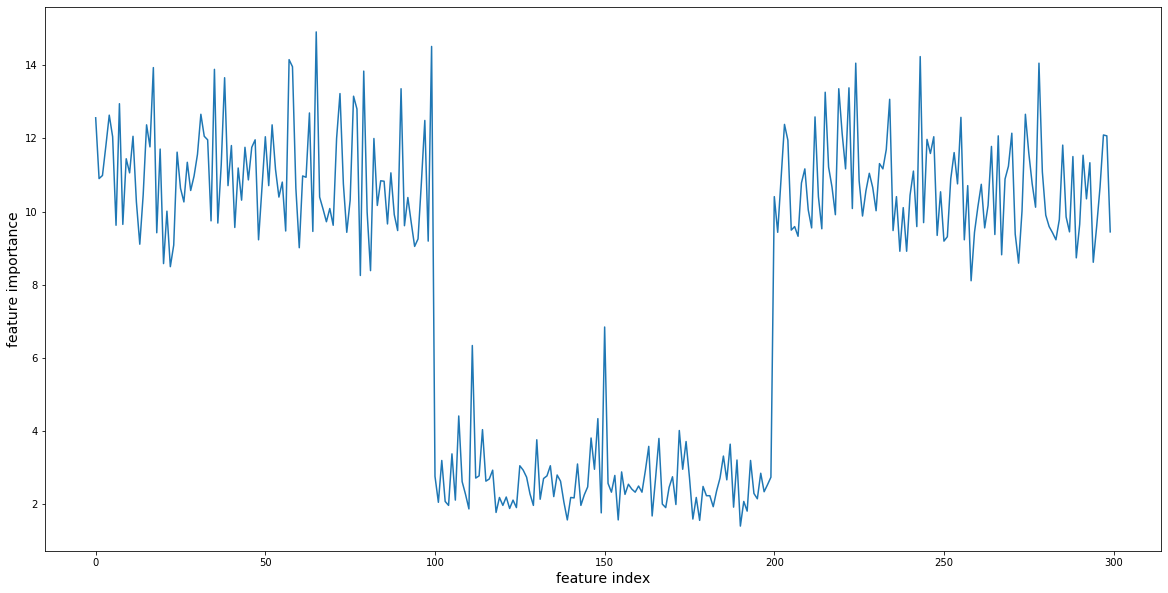

In [130]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_random_smiles_bm_fis.png', dpi=100)

In [131]:
plt.close()

### Shuffle SMILES vectors, leaving outputs the same (shuffle SMILES)
Trains model on fake reactions, testing on same test set of real ones

In [132]:
# Show SMILES dataset for comparison
X_train_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# Shuffle row ordering removing index
X_train_smiles_shuffle = np.random.permutation(X_train_smiles.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_smiles_shuffle_inputs = pd.DataFrame(
    X_train_smiles_shuffle, index=X_train_smiles.index, 
    columns=X_train_smiles.columns
)

# View new dataframe (can see inputs have changed)
X_train_smiles_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,67.0,49.0,67.0,67.0,61.0,67.0,67.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,91.0,67.0,64.0,93.0,49.0,40.0,67.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,67.0,61.0,67.0,61.0,67.0,40.0,67.0,67.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,79.0,91.0,67.0,64.0,72.0,93.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,61.0,67.0,61.0,67.0,67.0,40.0,67.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,49.0,67.0,61.0,67.0,67.0,61.0,67.0,49.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2682,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2683,67.0,67.0,49.0,61.0,67.0,40.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2684,67.0,67.0,35.0,67.0,67.0,78.0,40.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# But indices have stayed the same
X_train_smiles_shuffle_inputs.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [135]:
X_train_smiles.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2673, 2674, 2675, 2676, 2677, 2680, 2682, 2683, 2684, 2685],
           dtype='int64', length=2347)

In [136]:
# Check test set
X_test_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
15,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,67.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,67.0,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2667,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2678,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2679,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# Re-train and test model
start_time = time.time()
shuffle_smiles_file = 'shuffle_smiles_bm_gbm.model.joblib'
shuffle_smiles_bm_gbm = train_lgbm_classifier(
    X_train_smiles_shuffle_inputs, y_train, shuffle_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_smiles_bm_preds = shuffle_smiles_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
shuffle_smiles_bm_preds_labeled = get_top_k_preds(
    shuffle_smiles_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_smiles_bm_formatted_results = format_results_for_metrics(
    shuffle_smiles_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_smiles_bm_metrics = get_metrics_dict(
    shuffle_smiles_bm_formatted_results, type_count, 
    'shuffle_smiles_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_smiles_top_1_acc = shuffle_smiles_bm_metrics['top_1_acc']
shuffle_smiles_top_3_acc = shuffle_smiles_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 18.54863715171814 s
Top 1 accuracy for type  M  : 0.3320610687022901
Top 3 accuracy for type  M  : 0.7633587786259542
Top 1 accuracy for type  L  : 0.8702290076335878
Top 3 accuracy for type  L  : 0.9618320610687023
Top 1 accuracy for type  S  : 0.3320610687022901
Top 3 accuracy for type  S  : 0.6374045801526718
Top 1 accuracy for type  A  : 0.6564885496183206
Top 3 accuracy for type  A  : 0.8778625954198473
Top 1 accuracy for type  T  : 0.24427480916030533
Top 3 accuracy for type  T  : 0.5954198473282443
Top 1 accuracy for type  P  : 0.8015267175572519
Top 3 accuracy for type  P  : 0.9694656488549618
Top 1 accuracy for type  G  : 0.5076335877862596
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8625954198473282
Top 3 accuracy for type  O  : 0.9389312977099237
Top 1 accuracy for type  N  : 0.7938931297709924
Top 3 accuracy for type  N  : 1.0


## Fully random inputs (random inputs)
Combine random SMILES and random Mordred inputs

In [138]:
# Re-combine random SMILES and random Mordred dataframes
X_train_random_inputs = pd.concat(
    [X_train_random_smiles, X_train_random_mordred], axis=1
)
X_test_random_inputs = pd.concat(
    [X_test_random_smiles, X_test_random_mordred], axis=1
)

# View new dataframe
X_train_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,5,85,53,5,18,48,42,70,8,10,...,65896.745717,21783.792849,90571.847413,15291.794446,54431.749080,84963.454167,67394.218611,21900.689179,41838.985403,87138.695800
1,92,25,36,51,90,38,71,60,113,114,...,95469.496800,12270.742611,60509.173832,69898.547622,25294.579749,59245.572715,31562.254940,86068.170804,69612.983361,4937.408419
2,18,70,81,42,73,41,29,84,11,63,...,20183.349479,28114.399770,5834.468376,1883.315541,75105.389086,98100.663696,12622.826783,45342.852208,36986.530801,70518.526376
3,92,25,36,51,90,38,71,60,113,114,...,22853.240017,19021.345702,32563.385734,56316.077991,13665.376970,11462.129658,2226.777617,28523.405878,12932.115249,44550.922229
4,74,0,18,57,114,28,95,33,104,21,...,1440.742426,62512.695000,70904.947869,10492.272848,78949.361637,59930.811801,35726.355546,83267.226101,11291.650249,34905.382347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,32,75,49,85,24,8,58,2,64,72,...,1607.673482,53612.968615,62266.850393,71136.305212,55634.527611,599.404195,96918.776212,54260.152372,82708.459454,15235.335629
2682,19,19,13,63,104,57,76,65,35,34,...,98438.122419,388.973427,24023.551600,24762.293118,34101.512451,62727.492419,79420.169944,36004.778436,49291.214941,71981.687785
2683,33,72,1,92,46,109,97,48,57,24,...,87007.187648,92968.623724,1692.570206,11306.555689,68732.382127,81347.887831,47367.487686,43962.235110,34472.646075,76296.110693
2684,86,94,103,2,82,97,30,96,85,53,...,44281.101164,48196.719014,83814.301081,4453.932544,72435.959040,55613.213905,73056.965735,15270.443768,31161.551132,30746.842077


In [139]:
# Compare to original dataset
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,91.0,72.0,93.0,91.0,67.0,64.0,64.0,93.0,49.0,50.0,...,0,0.000000,0,1.230612,0.0,1,0,0.0,1,0.000000
1,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.296372,0.0,0,0,0.0,0,6.069221
2,67.0,49.0,67.0,50.0,67.0,61.0,67.0,67.0,49.0,67.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
3,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,0.206667,0.0,0,0,0.0,0,0.000000
4,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,0.0,...,0,0.000000,0,0.212336,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0,0.000000,0,1.093288,0.0,1,0,0.0,1,5.749512
2682,67.0,61.0,67.0,49.0,67.0,91.0,67.0,64.0,64.0,93.0,...,0,7.532037,0,2.638821,0.0,1,0,0.0,1,5.749512
2683,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,40.0,67.0,...,0,0.000000,0,1.191247,0.0,0,0,0.0,0,0.000000
2684,67.0,61.0,67.0,49.0,67.0,67.0,67.0,67.0,67.0,40.0,...,0,0.000000,0,1.196145,0.0,1,0,0.0,1,5.749512


In [140]:
X_test_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
15,91,56,32,23,29,50,17,90,86,72,...,61241.717485,36587.647972,75666.009268,20685.850690,72319.073588,74053.956202,1331.193481,48629.921801,34481.800448,96927.963209
26,23,24,66,106,57,73,6,81,41,102,...,4638.998757,11861.471399,55588.942286,15411.732400,5103.034443,42856.096003,24200.754348,3813.046661,63638.544125,62178.894706
27,99,50,32,69,94,38,19,11,75,7,...,82569.313866,25254.532249,16051.311073,61215.541013,56066.123416,37177.771397,7128.671584,77915.733413,45427.459039,59201.475392
36,3,113,56,3,53,59,73,107,48,103,...,70376.220441,27482.525366,45613.235772,96630.002089,31030.351076,65979.784931,54710.540172,17857.893180,63450.784938,13588.428707
46,42,75,102,83,86,105,51,14,12,31,...,5686.401564,34517.033704,55998.154151,24515.217510,67760.793120,92549.209726,8241.419287,16937.489905,34119.084128,18579.333164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,32,41,96,38,112,111,87,70,4,69,...,82223.160059,31787.363405,18998.090560,69303.280133,38770.468971,40215.321842,8772.273233,29667.039534,20667.071501,85549.436866
2667,92,25,36,51,90,38,71,60,113,114,...,45030.675814,11917.228737,18635.657632,61423.258043,67877.187613,28381.899155,28249.275712,13085.902661,13818.951524,74185.714012
2678,87,46,4,84,47,57,22,83,80,27,...,4444.432511,70810.617794,42937.718705,89502.200128,30144.787169,95442.961724,73191.417632,47327.203774,65316.647449,56760.534625
2679,9,86,14,35,55,30,64,22,11,15,...,47728.820930,71211.085007,57172.483285,56744.238153,88519.332442,40837.957308,80933.534799,7211.133943,49355.229364,54338.064492


In [141]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
15,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,40.0,67.0,...,0,0.000000,0,0.364082,0.0,0,0,0.00000,0,0.000000
26,67.0,35.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0,0.000000,0,0.444082,0.0,0,0,0.00000,0,33.380709
27,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0,0.000000,0,0.927347,0.0,0,0,0.00000,0,33.380709
36,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,0.990204,0.0,0,0,0.00000,0,67.877780
46,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,40.0,67.0,...,1,0.000000,1,1.843492,0.0,0,0,5.90718,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,67.0,67.0,67.0,67.0,67.0,67.0,67.0,35.0,67.0,0.0,...,0,0.000000,0,1.395828,0.0,0,0,0.00000,0,5.749512
2667,67.0,49.0,67.0,67.0,50.0,67.0,67.0,49.0,67.0,61.0,...,0,0.000000,0,1.054875,0.0,0,0,0.00000,0,0.000000
2678,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0,7.392053,0,2.695011,0.0,1,0,0.00000,1,5.749512
2679,67.0,92.0,67.0,61.0,67.0,92.0,67.0,61.0,67.0,92.0,...,0,0.000000,0,1.013288,0.0,1,0,0.00000,1,5.749512


In [142]:
# Re-train and test model
start_time = time.time()
random_inputs_file = 'random_inputs_bm_gbm.model.joblib'
random_inputs_bm_gbm = train_lgbm_classifier(
    X_train_random_inputs, y_train, random_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_inputs_preds = random_inputs_bm_gbm.predict_proba(
    X_test_random_inputs
)

# Get top-k predicted rankings from prediction set
random_inputs_preds_labeled = get_top_k_preds(
    random_inputs_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_inputs_formatted_results = format_results_for_metrics(
    random_inputs_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_inputs_metrics = get_metrics_dict(
    random_inputs_formatted_results, type_count, 'random_inputs_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_inputs_top_1_acc = random_inputs_metrics['top_1_acc']
random_inputs_top_3_acc = random_inputs_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 589.3626568317413 s
Top 1 accuracy for type  M  : 0.6221374045801527
Top 3 accuracy for type  M  : 0.8587786259541985
Top 1 accuracy for type  L  : 0.9007633587786259
Top 3 accuracy for type  L  : 0.9885496183206107
Top 1 accuracy for type  S  : 0.44656488549618323
Top 3 accuracy for type  S  : 0.767175572519084
Top 1 accuracy for type  A  : 0.7061068702290076
Top 3 accuracy for type  A  : 0.9122137404580153
Top 1 accuracy for type  T  : 0.4580152671755725
Top 3 accuracy for type  T  : 0.7480916030534351
Top 1 accuracy for type  P  : 0.8435114503816794
Top 3 accuracy for type  P  : 0.9732824427480916
Top 1 accuracy for type  G  : 0.7404580152671756
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8969465648854962
Top 3 accuracy for type  O  : 0.9770992366412213
Top 1 accuracy for type  N  : 0.8320610687022901
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [143]:
num_estimators = len(random_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_inputs_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('pkr_random_inputs_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['35', '0', '17', '77', '59', '32', '224', '11', '220', '71', '298',
       '65', '76', '79', '87', '40', '2', '46', '99', '231'],
      dtype='object')
Index(['35', '0', '17', '77', '59', '32', '224', '11', '220', '71', '298',
       '65', '76', '79', '87', '40', '2', '46', '99', '231'],
      dtype='object')
Index(['product_SsF', 'product_n8ARing', 'rdfred_1_SddssS', 'rdfred_1_Mi',
       'rdfred_1_TopoPSA(NO)', 'product_NaaaC', 'rdfred_1_SRW03',
       'rdfred_2_n8AHRing', 'product_ATSC0m', 'rdfred_1_ATSC5m',
       'product_ATSC1se', 'rdfred_1_NtCH', 'product_ATS5se', 'product_Spe',
       'product_MWC07', 'product_n3AHRing', 'rdfred_1_Xpc-4dv',
       'rdfred_1_ATS8m', 'product_n11FARing', 'rdfred_1_n6HRing'],
      dtype='object')


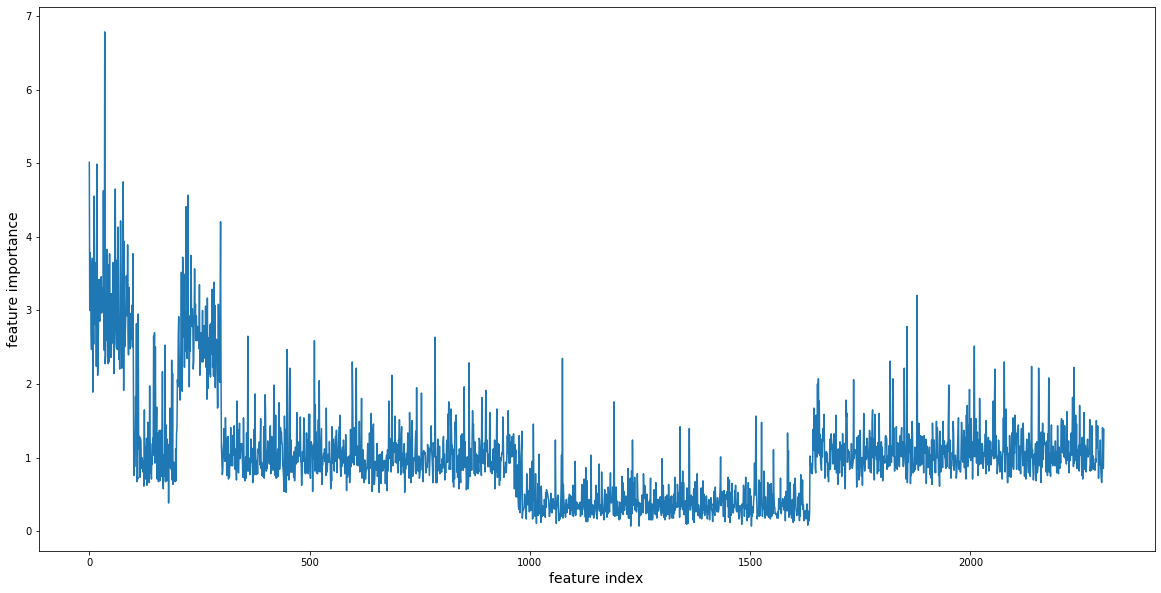

In [146]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_random_inputs_fis.png', dpi=100)

In [147]:
plt.close()

## Classifier trellis method (CT)

In [149]:
def train_one_lgbm_classifier(X_train, y_train):
    """
    Trains one LightGBM binary classifier for a single bin in the label space.
    Differs from train_lgbm_classifier as is not wrapped in a
    OneVsRestClassifier and does not add single classifiers to joblib.
    Model parameters are otherwise identical
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    clf = LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    )
    clf.fit(X_train, y_train)
    return clf


class ClassifierTrellis:
    def __init__(self, struct, fit_func):
        self.struct = struct
        self.fit_func = fit_func
        self.width = len(struct)
        self.clfs = [[None for col in range(self.width)]
                     for row in range(self.width)]
    
    def create_X_trellis(self, X, Y, row, col):
        """
        Forms trellis structure at given position in grid with propagation
        directions from label dependency matrix
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (int)row: current row index
            (int)col: current column index
            
        RETURNS:
            (pandas.DataFrame)X_trellis: trellis structure at given position
            in grid
        """
        # Set empty label propagation matrix
        n_rows = len(X)
        dep_Y = pd.DataFrame({
            'topleft': np.zeros(n_rows),
            'left': np.zeros(n_rows),
            'top': np.zeros(n_rows)
        }, index=X.index)

        # Fill in dependency matrix with output labels in each applicable
        # propagation direction
        if row > 0:
            dep_Y['top'] = Y[self.struct[row - 1][col][1]]
        if col > 0:
            dep_Y['left'] = Y[self.struct[row][col - 1][1]]
        if row > 0 and col > 0:
            dep_Y['topleft'] = Y[self.struct[row - 1][col - 1][1]]
        
        # Append label values to input vectors
        X_trellis = X.merge(dep_Y, left_index=True, right_index=True)
        return X_trellis

    def fit(self, X, Y, train_on_predictions=False):
        """
        Fits a classifier for each label in the trellis
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (Bool)train_on_predictions: whether to append predicted or 
            ground truth labels as the propagated inputs in training
            
        RETURNS:
            self.clfs will be fit to training data
        """
        # Set empty dataframe to fill in predicted outputs
        preds_df = pd.DataFrame(index=X.index)
        
        # Iterate through the trellis updating inputs and fitting classifiers
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                # Get current label bin to be predicted
                target_col = self.struct[row][col][1]
                if train_on_predictions:
                    # Use predictions to make trellis columns
                    X_trellis = self.create_X_trellis(X, preds_df, row, col)
                else:
                    # Use ground truth to make trellis columns
                    X_trellis = self.create_X_trellis(X, Y, row, col)
                #print("Training clf at ({}, {}) called: {}".format(row, col, target_col))
                # Train classifier for current label with updated inputs
                self.clfs[row][col] = self.fit_func(X_trellis, Y[target_col])

                # Update prediction set with outputs from current classifier
                if train_on_predictions:
                    # Create predictions for use in training
                    #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                    col_preds = self.clfs[row][col].predict_proba(X_trellis)
                    preds_df[target_col] = col_preds[:,1]

        
    def predict(self, X):
        """
        Make predictions using trellis classifiers
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            
        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = col_preds[:,1]
        return preds_df
    
    def predict_on_zeros(self, X):
        """
        Make predictions using trellis classifiers removing propagated inputs

        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe

        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = np.zeros(col_preds[:,1].shape)
        return preds_df

## Full CT model
### Trained on propagated predictions

In [150]:
# Construct classifier trellis
pkr_ct = ClassifierTrellis(struct, train_one_lgbm_classifier)

# Train CT model
start_time = time.time()
pkr_ct.fit(X_train, y_train, train_on_predictions=True)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Save CT model
joblib.dump(pkr_ct, 'pkr_ct_gbms.model.joblib')

# Make predictions with trained model
ct_full_preds = pkr_ct.predict(X_test)

# Re-index to match dictionary order
ct_full_preds = ct_full_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
ct_full_preds_labeled = get_top_k_preds(
    ct_full_preds.values, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
ct_full_formatted_results = format_results_for_metrics(
    ct_full_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
ct_full_metrics = get_metrics_dict(
    ct_full_formatted_results, type_count, 'ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
ct_full_top_1_acc = ct_full_metrics['top_1_acc']
ct_full_top_3_acc = ct_full_metrics['top_k_acc']

Training complete. Training time: 428.89559388160706 s
Top 1 accuracy for type  M  : 0.7786259541984732
Top 3 accuracy for type  M  : 0.9312977099236641
Top 1 accuracy for type  L  : 0.9236641221374046
Top 3 accuracy for type  L  : 0.9923664122137404
Top 1 accuracy for type  S  : 0.6259541984732825
Top 3 accuracy for type  S  : 0.8549618320610687
Top 1 accuracy for type  A  : 0.8015267175572519
Top 3 accuracy for type  A  : 0.9274809160305344
Top 1 accuracy for type  T  : 0.5648854961832062
Top 3 accuracy for type  T  : 0.8320610687022901
Top 1 accuracy for type  P  : 0.8702290076335878
Top 3 accuracy for type  P  : 0.9847328244274809
Top 1 accuracy for type  G  : 0.8854961832061069
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8893129770992366
Top 3 accuracy for type  O  : 0.9885496183206107
Top 1 accuracy for type  N  : 0.851145038167939
Top 3 accuracy for type  N  : 1.0


### Control withholding predictions

In [151]:
# Make predictions with no propagated values
zero_input_ct_preds = pkr_ct.predict_on_zeros(X_test)

# Re-index to match dictionary order
zero_input_ct_preds = zero_input_ct_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
zero_input_ct_preds_labeled = get_top_k_preds(
    zero_input_ct_preds.values, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
zero_input_ct_formatted_results = format_results_for_metrics(
    zero_input_ct_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
zero_input_ct_metrics = get_metrics_dict(
    zero_input_ct_formatted_results, type_count, 'zero_input_ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
zero_input_ct_top_1_acc = zero_input_ct_metrics['top_1_acc']
zero_input_ct_top_3_acc = zero_input_ct_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.21374045801526717
Top 3 accuracy for type  M  : 0.21374045801526717
Top 1 accuracy for type  L  : 0.04961832061068702
Top 3 accuracy for type  L  : 0.11068702290076336
Top 1 accuracy for type  S  : 0.36259541984732824
Top 3 accuracy for type  S  : 0.6755725190839694
Top 1 accuracy for type  A  : 0.14122137404580154
Top 3 accuracy for type  A  : 0.25190839694656486
Top 1 accuracy for type  T  : 0.019083969465648856
Top 3 accuracy for type  T  : 0.4580152671755725
Top 1 accuracy for type  P  : 0.026717557251908396
Top 3 accuracy for type  P  : 0.9389312977099237
Top 1 accuracy for type  G  : 0.4580152671755725
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.026717557251908396
Top 3 accuracy for type  O  : 0.061068702290076333
Top 1 accuracy for type  N  : 0.18702290076335878
Top 3 accuracy for type  N  : 1.0


### Feature importances

In [152]:
all_fis = []

for i in range(len(pkr_ct.clfs)):
    for j in range(len(pkr_ct.clfs[i])):
        try:
            fis_ij = pkr_ct.clfs[i][j].feature_importances_
            smiles_fis_ij = fis_ij[:300].tolist()
            mordred_fis_ij = fis_ij[300:2304].tolist()
            reagent_fis_ij = fis_ij[2304:].tolist()
            avg_reagent_fis_ij = [(np.average(np.array(reagent_fis_ij)))]
            full_fis_ij = smiles_fis_ij + mordred_fis_ij + avg_reagent_fis_ij
            all_fis.append(full_fis_ij)
        except:
            continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:2304]
reagent_fis = average_fis[2304:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

#fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('pkr_ct_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

#top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fis)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

[2304    1    4    7    2  205 2276  697  223   12    3  207   14   19
  224  675  217   15 2233    5]
Index(['1', '4', '7', '2', '205', '223', '12', '3', '207', '14', '19', '224',
       '217', '15', '5', '219', '8', '11', '226', '6'],
      dtype='object')
Index(['product_SsssCH', 'rdfred_1_SddC', 'rdfred_1_StsC', 'product_SdssC',
       'product_EState_VSA3', 'product_SdsCH', 'product_PEOE_VSA7',
       'rdfred_1_SdsCH', 'product_Xch-6dv', 'product_JGI3', 'product_JGI2',
       'product_ATSC1dv', 'product_Xch-5dv', 'product_ATSC3d',
       'product_Xch-6d', 'product_ATSC6dv', 'product_ATSC6i',
       'product_ATSC3dv', 'product_JGI4', 'product_PEOE_VSA8'],
      dtype='object')


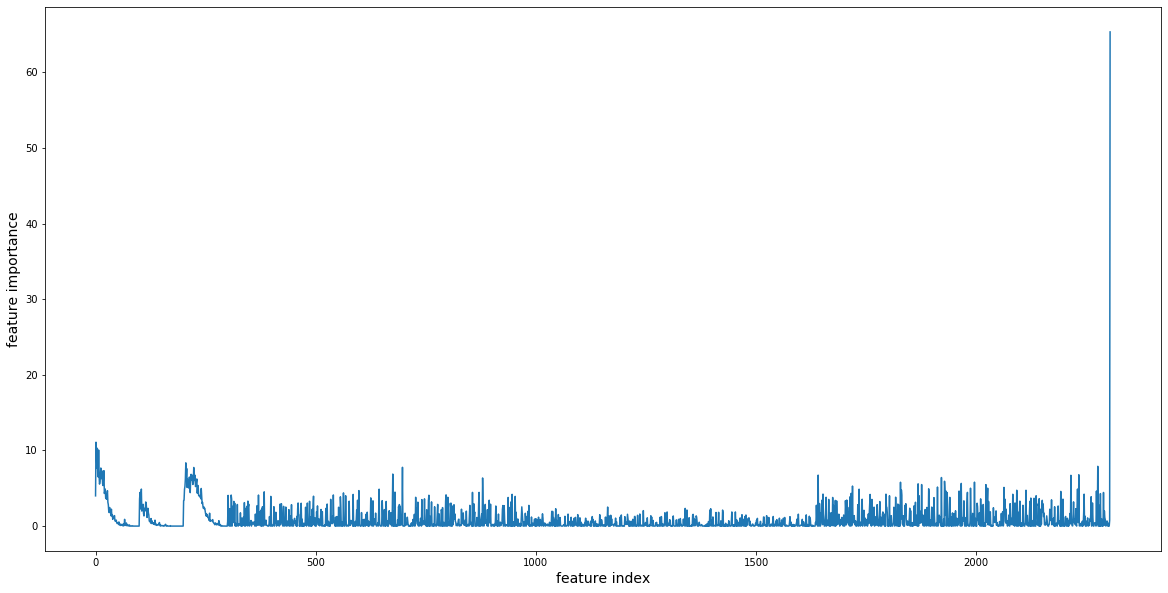

In [153]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('pkr_full_ct_fis.png', dpi=100)

In [154]:
plt.close()

## Dummy model

In [155]:
# Train model
start_time = time.time()
dummy_model_file = 'dummy_model.joblib'
dummy_clf = train_lgbm_classifier(
    np.zeros((len(y_train), 2)), y_train, dummy_model_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
dummy_preds = dummy_clf.predict_proba(
    np.zeros((len(y_test), 2))
)

# Get top-k predicted rankings from prediction set
dummy_preds_labeled = get_top_k_preds(
    dummy_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
dummy_formatted_results = format_results_for_metrics(
    dummy_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
dummy_metrics = get_metrics_dict(
    dummy_formatted_results, type_count, 'dummy_metrics.json'
)

# View top-1 and top-3 accuracy metrics
dummy_top_1_acc = dummy_metrics['top_1_acc']
dummy_top_3_acc = dummy_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 81 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 1.19185209274292 s
Top 1 accuracy for type  M  : 0.4389312977099237
Top 3 accuracy for type  M  : 0.7862595419847328
Top 1 accuracy for type  L  : 0.8778625954198473
Top 3 accuracy for type  L  : 0.9809160305343512
Top 1 accuracy for type  S  : 0.36259541984732824
Top 3 accuracy for type  S  : 0.6755725190839694
Top 1 accuracy for type  A  : 0.6679389312977099
Top 3 accuracy for type  A  : 0.8816793893129771
Top 1 accuracy for type  T  : 0.3435114503816794
Top 3 accuracy for type  T  : 0.6297709923664122
Top 1 accuracy for type  P  : 0.8320610687022901
Top 3 accuracy for type  P  : 0.9732824427480916
Top 1 accuracy for type  G  : 0.5419847328244275
Top 3 accuracy for type  G  : 1.0
Top 1 accuracy for type  O  : 0.8931297709923665
Top 3 accuracy for type  O  : 0.9351145038167938
Top 1 accuracy for type  N  : 0.8129770992366412
Top 3 accuracy for type  N  : 1.0
